In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import sklearn as sk
import joblib
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,cross_validate
import timeit

In [2]:
random_seed = 108
test_size = 0.2

In [3]:
score_df = pd.DataFrame.from_dict(
    {'model': [],
 'test_accuracy':[],
 'outcome':[],
    'fit_time':[],
    'score_time':[],
    'test_precision':[],
    'test_recall':[],
    'test_f1':[],
    'test_roc_auc':[]}
)


test_df = pd.DataFrame.from_dict(
    {'model': [],
    'accuracy':[],
     'precision':[],
     'recall':[],
     'f1_score':[],
     'auc':[],
     'outcome':[]})


scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
          'f1': 'f1',
          'roc_auc': 'roc_auc'}

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

In [5]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score,f1_score
def evaluate_model(model,X,y):
    yhat = model.predict(X)
    yhat_proba = model.predict(X)
    result_dict = {}
    result_dict['accuracy'] = [accuracy_score(y,yhat)]
    result_dict['precision'] = [precision_score(y,yhat)]
    result_dict['recall'] = [recall_score(y,yhat)]
    result_dict['f1_score'] = [f1_score(y,yhat)]
    result_dict['auc'] = [roc_auc_score(y,yhat_proba)]
    
    df = pd.DataFrame.from_dict(result_dict)
    return df

In [6]:
df = pd.read_excel(io='AUSCOVID_DATA_2023-04-02_1133.xlsx')
# excluded efgr as derivative of creatinine
# 
cols = ['age','sex','healthcare_worker','hypertension',
        'hypercholesterolemia',
       'diabetes' ,'smoker','copd','asthma','ckd','dialysis','height','weight','sbp','dbp',
        'heart_rate','respiratory_rate','temperature','spo2','crp',
        'lymphocytes','total_wcc','platelets','albumin','ldh','d_dimer','ferritin','haemoglobin',
        'creatinine','alt','lactate_venous','chest_xray','vaccinated','pacemaker','troponin_uln',
         #'coronary_artery_disease',
    #'heart_failure_cardiomyopathy',
    #'af_flutter',
    #'severe_valvular_disease',
    #'stroke_tia',
    #'pad']
        'coronary_med_history_col']

# get rid of past medical_history
# 'fio2','po2','pco2'

coronary_med_history_col = [
    'coronary_artery_disease',
    'heart_failure_cardiomyopathy',
    'af_flutter',
    'severe_valvular_disease',
    'stroke_tia',
    'pad']

cardio_complication = [
    'pericarditis',
    'new_2nd_degree_heart_block',
    'new_3rd_degree_heart_block',
    'conscious_sustained_vt',
    'new_cardiomyopathy_hf',
    'new_af_flutter',
    'myocarditis_myopericarditis',
    'pulm_embolus',
    'cardiac_arrest'
]

# replace No's to 0
for col in coronary_med_history_col + cardio_complication + ['past_medical_history']:
    df[col] = df[col].replace(2, 0)


df['death'] = [1 if x == 1 or x == 2 else 0 for x in df['discharge_status']]
df['vaccinated'] = [1 if x == 2 or x == 3 or  x == 4 else 0 for x in df['vaccination_status']]
df['pacemaker'] = [1 if x == 1 else 0 for x in df['ppm_icd']]
df['coronary_med_history_col'] = df[coronary_med_history_col].any(axis=1)


categorical_col = ['sex','healthcare_worker','hypertension',
        'hypercholesterolemia','diabetes', 'smoker','copd','asthma','ckd','dialysis',
                   'chest_xray','vaccinated','pacemaker','troponin_uln',
                     #'coronary_artery_disease',
    #'heart_failure_cardiomyopathy',
    #'af_flutter',
    #'severe_valvular_disease',
    #'stroke_tia',
    #'pad']
             'coronary_med_history_col']



predictor = ['intubation_dummy','death','cardio_complication']

df['intubation_dummy'] =  [1 if x == 1 else 0 for x in df['intubation']]
df['cardio_complication'] = df[cardio_complication].any(axis=1).astype(float)


data_predictor = df[predictor]
data = df[cols+predictor]

In [7]:
float_col = ['height','sbp','dbp','heart_rate','weight','respiratory_rate','temperature','spo2','crp',
        'lymphocytes','total_wcc','platelets','albumin','ldh','d_dimer','ferritin','haemoglobin',
        'creatinine','alt','lactate_venous']
int_col = ['age']

In [16]:
df.query('coronary_med_history_col == True')

,record_id,redcap_data_access_group,study_site,age,sex,healthcare_worker,nursing_home,past_medical_history,coronary_artery_disease,heart_failure_cardiomyopathy,...,discharge_status,other_hospital,special_interim_report,australian_cardiovascular_covid19_database_complete,death,vaccinated,pacemaker,coronary_med_history_col,intubation_dummy,cardio_complication
3,4,ryde_hospital,25,92,2,2.0,1.0,1,0.0,0.0,...,5,NaN,2.0,2,0,0,1,True,0,0.0
7,133-4,royal_north_shore,1,77,1,2.0,2.0,1,1.0,0.0,...,7,NaN,2.0,2,0,0,1,True,0,0.0
26,134-5,prince_of_wales_ho,7,68,1,2.0,2.0,1,0.0,0.0,...,7,NaN,2.0,2,0,0,1,True,0,0.0
27,134-6,prince_of_wales_ho,7,72,1,2.0,2.0,1,1.0,0.0,...,7,NaN,2.0,2,0,0,1,True,0,0.0
28,134-7,prince_of_wales_ho,7,94,1,2.0,2.0,1,0.0,0.0,...,7,NaN,2.0,2,0,0,1,True,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,353-67,royal_melbourne_ho,31,67,1,2.0,2.0,1,1.0,0.0,...,7,NaN,2.0,2,0,0,1,True,0,0.0
1697,353-69,royal_melbourne_ho,31,91,2,2.0,2.0,1,1.0,0.0,...,2,NaN,2.0,2,1,0,1,True,0,1.0
1703,353-75,royal_melbourne_ho,31,81,1,2.0,1.0,1,1.0,1.0,...,2,NaN,2.0,2,1,0,1,True,0,0.0
1704,353-76,royal_melbourne_ho,31,76,1,2.0,2.0,1,0.0,0.0,...,7,NaN,2.0,2,0,0,1,True,0,0.0


In [18]:
df.loc[7,coronary_med_history_col + ['coronary_med_history_col']]

coronary_artery_disease          1.0
heart_failure_cardiomyopathy     0.0
af_flutter                       0.0
severe_valvular_disease          0.0
stroke_tia                       0.0
pad                              0.0
coronary_med_history_col        True
Name: 7, dtype: object

In [8]:
data['platelets'] = data['platelets'].astype(str).str.replace(",", "").str.replace(".", "").astype(float)

C:\Users\Harrison Nguyen\AppData\Local\Temp\ipykernel_23532\935426440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['platelets'] = data['platelets'].astype(str).str.replace(",", "").str.replace(".", "").astype(float)


In [9]:
df_dummy =  pd.get_dummies(
        data,
        columns = categorical_col, 
        dummy_na=False,
        drop_first=True)

In [10]:
df_dummy_cat_cols = [ 'sex_2',
       'healthcare_worker_2.0', 'hypertension_2.0', 'hypercholesterolemia_2.0',
       'diabetes_2.0', 'smoker_2.0', 'copd_2.0', 'asthma_2.0', 'ckd_2.0',
       'dialysis_2.0', 'dialysis_3.0', 'chest_xray_2', 'chest_xray_3',
       'vaccinated_1', 'pacemaker_1', 'troponin_uln_2.0',
       'coronary_med_history_col_True']

In [11]:
from sklearn.model_selection import train_test_split
train,test= train_test_split(df_dummy, test_size=test_size, random_state=random_seed)

In [12]:
scoring_method = 'roc_auc'
cv_result_filename = "result/outcome_v2.csv"
test_result_filename = "result/test_result_v2.csv"

In [13]:
def train_model(X,y,y_name,model,model_name,
                impute=True,
                scale=True,
                oversample=False,
                feature_select=None,
                categorical_features=None,
               score_method='accuracy'):
    pipeline_steps = []
    
    if impute:
        pipeline_steps.append( ('imputer',SimpleImputer(missing_values=np.nan, strategy='median')))
        
    if scale:
        pipeline_steps.append(  ('scaler',StandardScaler()))
    
    if oversample:
        cat_col_index = [i for i, x in enumerate(X.columns) if x in df_dummy_cat_cols]
        pipeline_steps.append(("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)))
        model_name += '_oversample'
            
    if feature_select is not None:
         pipeline_steps.append(("feature_select",feature_select))
        
    
    pipeline_steps.append(  ('model',model))
    
    pipe = Pipeline(steps = pipeline_steps)
    
    cv_result = cross_validate(pipe, X, y, cv=5,scoring=scoring)
    
    results = [{k : v.mean() for k, v in cv_result.items()}]
    

    df_cv_result = pd.DataFrame(results, index=[model_name])
    df_cv_result["outcome"] = y_name
    df_cv_result["model"] = model_name

    
    pipe.fit(X,y)
    joblib.dump(pipe,"model/" + model_name + "_" + y_name +".pickle")
    
    
    return pipe,df_cv_result

In [14]:
def plot_coef(model,model_name,columns):
    
    if "feature_select" in model.named_steps:
        feature_select = model.named_steps["feature_select"].support_
        columns = columns[feature_select]
        
    coefs = model.named_steps["model"].coef_
    coef_df = pd.DataFrame(data = {'variable' : columns,
                          'value' : coefs[0],
                           'mag':   coefs[0]    })

    coef_df = coef_df.sort_values('mag', ascending=False)
    plt.figure(figsize=(18, 18))
    ax = sns.barplot(
        data=coef_df, x="variable", y="mag")
    ax.set_title("Coefficient for " + p)
    plt.setp(ax.get_xticklabels(), rotation=90)

    plt.savefig("figure/" + model_name + "_" +p+".png",bbox_inches="tight")
    return ax

In [22]:
n_features = ['all']

In [23]:
for model_type in ['l1','l2','elasticnet']:
    for n in n_features:
        for use_oversample in [True]:

            for p in predictor:
                print(model_type + " " + str(use_oversample) + " " + p + " " + str(n))
                start_time = timeit.default_timer()

                if model_type == 'l1':
                    pre_train_model = LogisticRegression(random_state=random_seed,max_iter = 5000,penalty = 'l1',n_jobs=4,solver = 'saga')
                    model_name = "l1_feature_selection" + str(n)
                    param_grid = {
                        "logistic__C": np.logspace(1e-3,1,num=10)
                    }
                elif model_type == 'l2':
                    pre_train_model = LogisticRegression(random_state=random_seed,max_iter = 1000,penalty = 'l2',n_jobs=4,solver = 'lbfgs')
                    model_name = "l2_feature_selection" + str(n)
                    param_grid = {
                        "logistic__C": np.logspace(1e-3,1,num=10)
                    }
                elif model_type == 'elasticnet':
                    pre_train_model = LogisticRegression(random_state=random_seed,max_iter = 5000,penalty='elasticnet',solver='saga') 
                    model_name = "elasticnet_feature_selection" + str(n)

                    param_grid = {
                        "logistic__C": np.linspace(1e-3,1,num=15),
                        "logistic__l1_ratio": np.linspace(1e-1,1,num=5)
                    }

                y_train = train[p]
                X_train = train.drop(predictor, axis=1)

                cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]

                if use_oversample:
                    pre_train_pipeline = [
                        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
                        ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
                        ("scaler", StandardScaler()), 
                        ("logistic", pre_train_model)
                    ]
                    model_name += "_oversample"
                else:
                     pre_train_pipeline = [
                        ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
                        ("scaler", StandardScaler()), 
                        ("logistic", pre_train_model)
                    ]

                pipeline = Pipeline(steps=pre_train_pipeline)

                grid = GridSearchCV(pipeline,
                                param_grid = param_grid,cv=5,scoring=scoring_method)


                grid.fit(X_train, y_train)

                if model_type == 'l1':
                    model = LogisticRegression(max_iter = 1000,penalty = 'l1',C = grid.best_params_["logistic__C"],solver = 'saga')
                    feature_select_model =  SequentialFeatureSelector(LogisticRegression(max_iter = 1000,penalty = 'l1',
                                                                  C = grid.best_params_["logistic__C"],solver = 'saga'), 
                                               n_features_to_select=n,scoring=scoring_method)
                elif model_type == 'l2':
                    model = LogisticRegression(max_iter = 1000,penalty = 'l2',C = grid.best_params_["logistic__C"])
                    feature_select_model =   SequentialFeatureSelector(LogisticRegression(max_iter = 1000,penalty = 'l2',
                                                                  C = grid.best_params_["logistic__C"]), 
                                               n_features_to_select=n,scoring=scoring_method)
                elif model_type == 'elasticnet':
                    model = LogisticRegression(random_state=random_seed,
                                               max_iter = 5000,
                                               penalty='elasticnet',
                                               solver='saga', 
                                               C = grid.best_params_["logistic__C"],
                                              l1_ratio=grid.best_params_["logistic__l1_ratio"])
                    feature_select_model = SequentialFeatureSelector(
                         LogisticRegression(
                             random_state=random_seed,
                             max_iter = 5000,
                             penalty='elasticnet',
                             solver='saga',
                             C = grid.best_params_["logistic__C"],
                            l1_ratio=grid.best_params_["logistic__l1_ratio"]), 
                         n_features_to_select=n,scoring=scoring_method)



                pipe,df_cv_result = train_model(
                                        X_train,
                                        y_train,
                                        p,
                                        model,
                                        model_name,
                                        #feature_select=feature_select_model,
                                        score_method=scoring_method,
                                        oversample=use_oversample
                                    )


                score_df = pd.concat([score_df,df_cv_result],ignore_index=True)
                elapsed = timeit.default_timer() - start_time
                print("time taken: ",elapsed)

l1 True intubation_dummy all
time taken:  98.47643269999935
l1 True death all
time taken:  37.39378299999953
l1 True cardio_complication all
time taken:  57.15881720000016
l2 True intubation_dummy all
time taken:  43.710036799999216
l2 True death all
time taken:  20.229480600000898
l2 True cardio_complication all
time taken:  20.848318399999698
elasticnet True intubation_dummy all
time taken:  326.1111199999996
elasticnet True death all
time taken:  190.12287939999987
elasticnet True cardio_complication all
time taken:  261.1436460999994


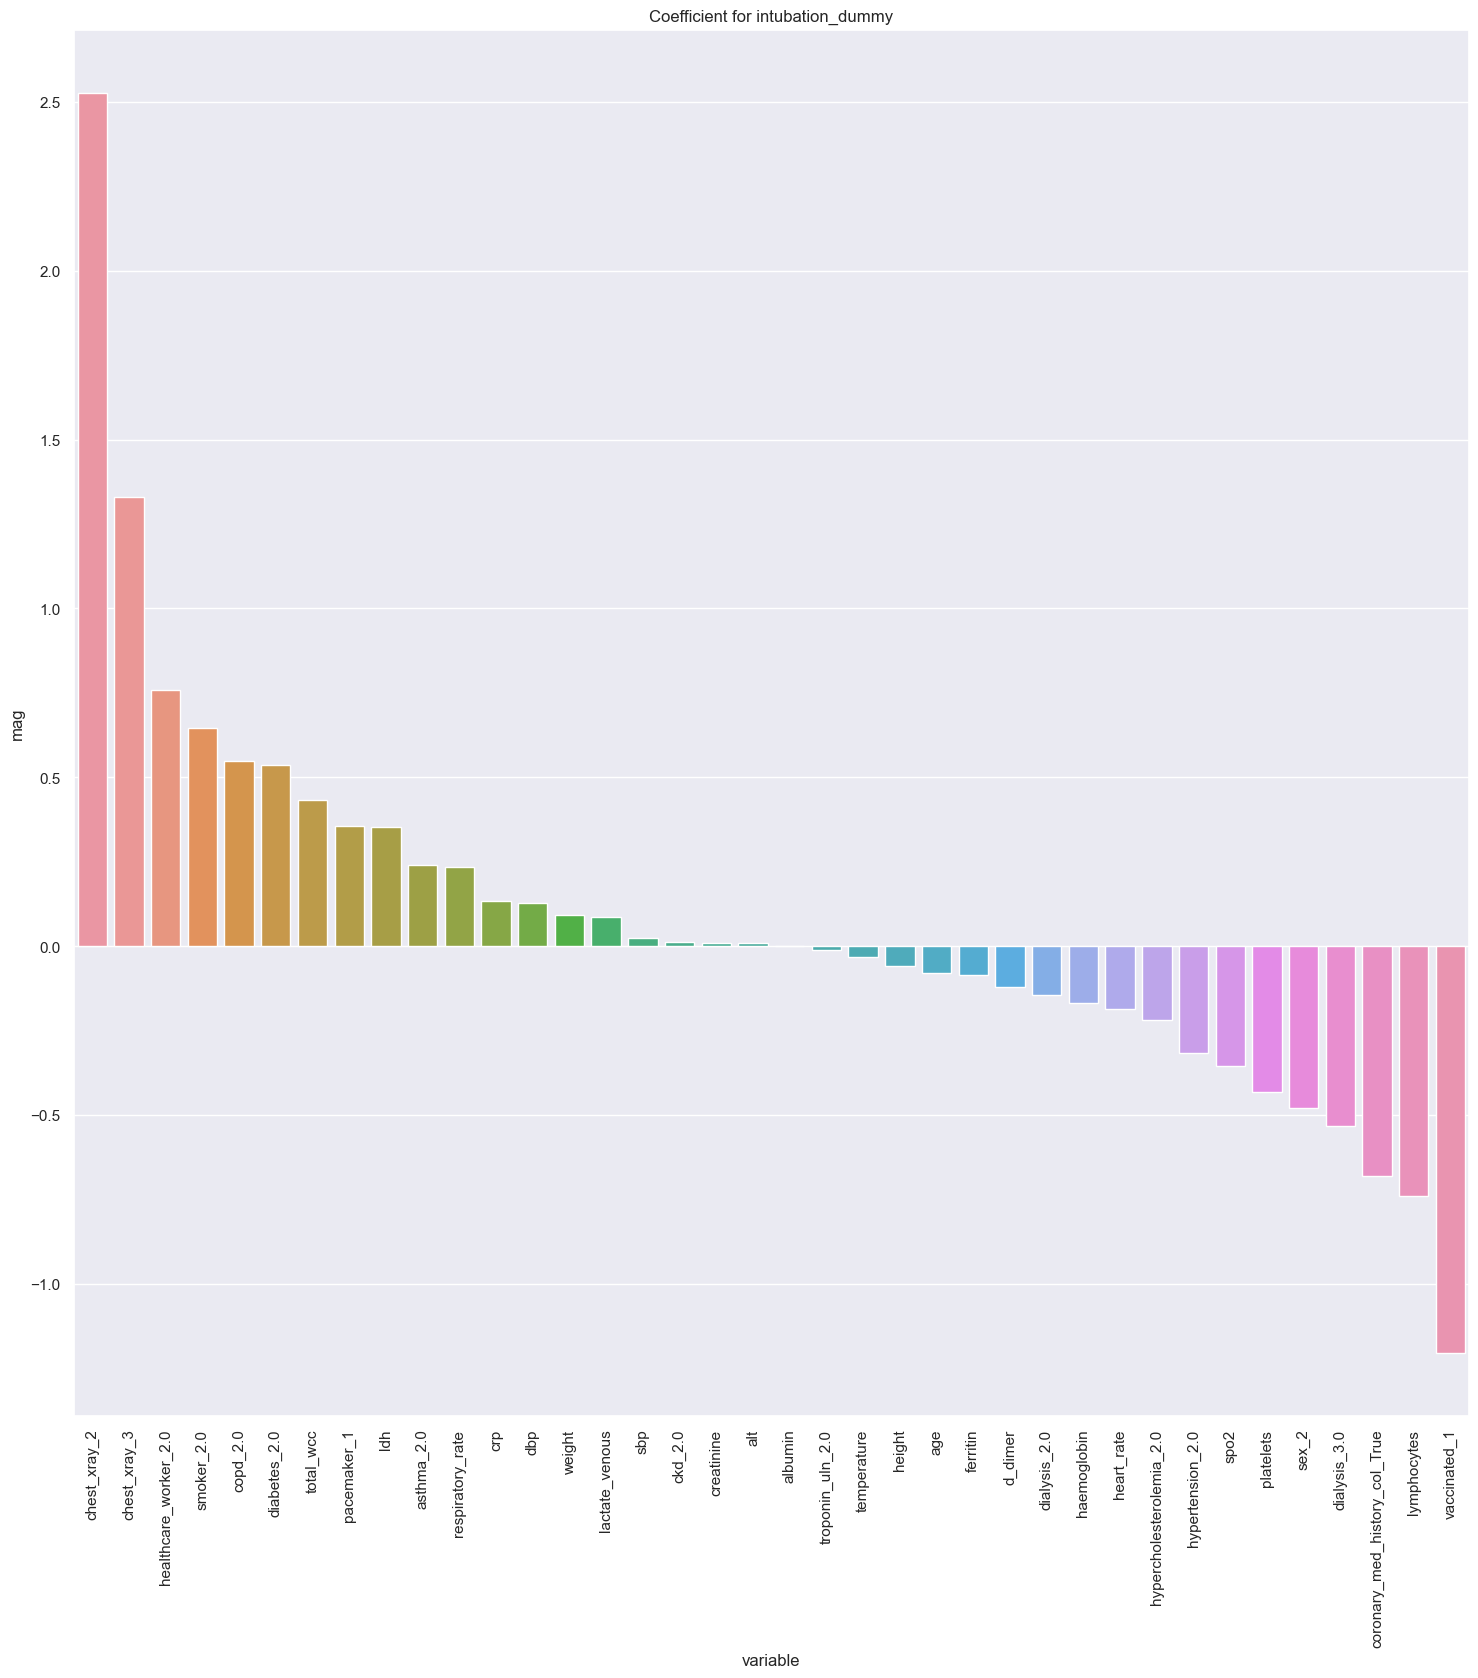

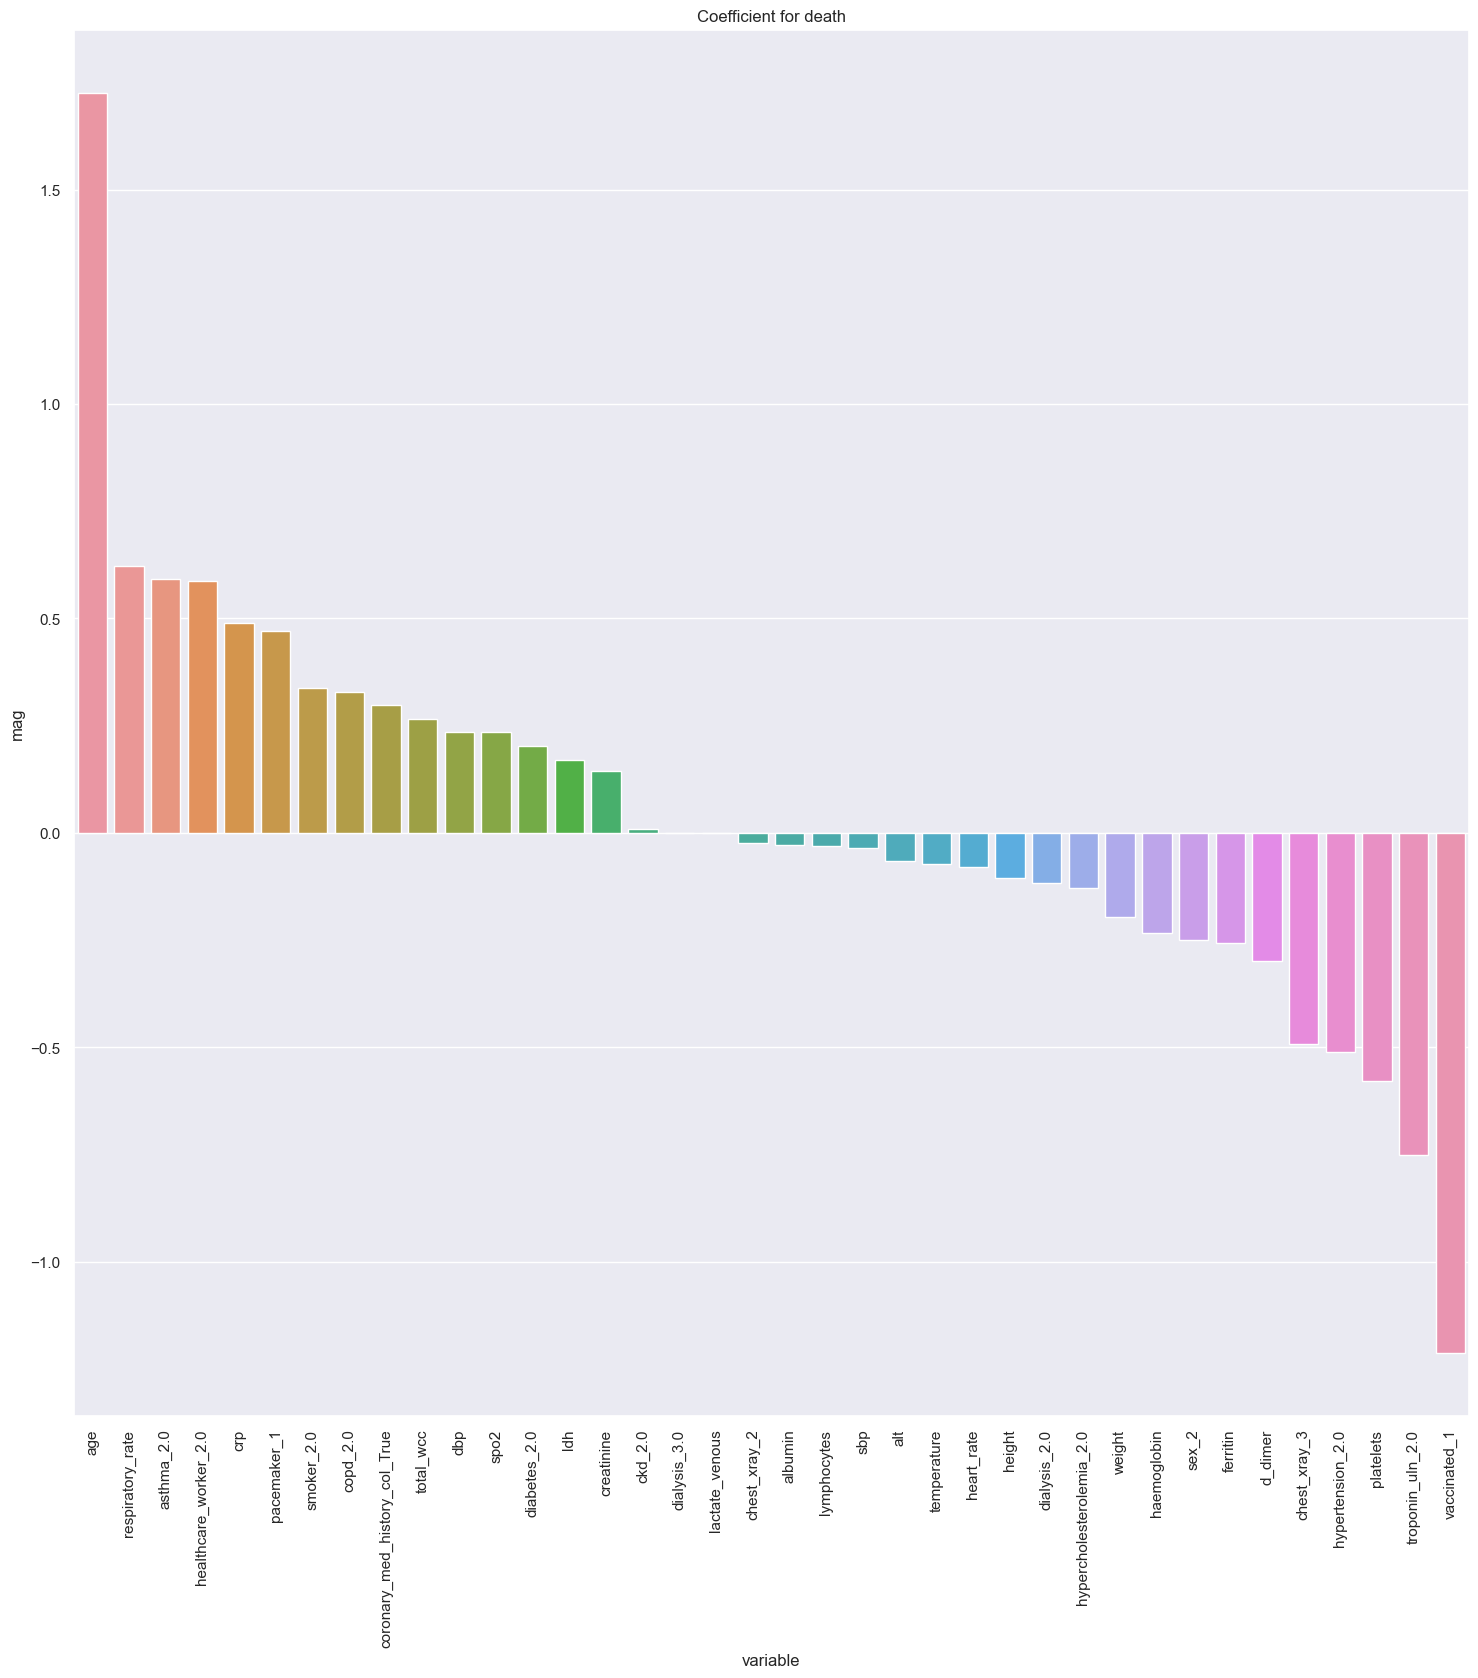

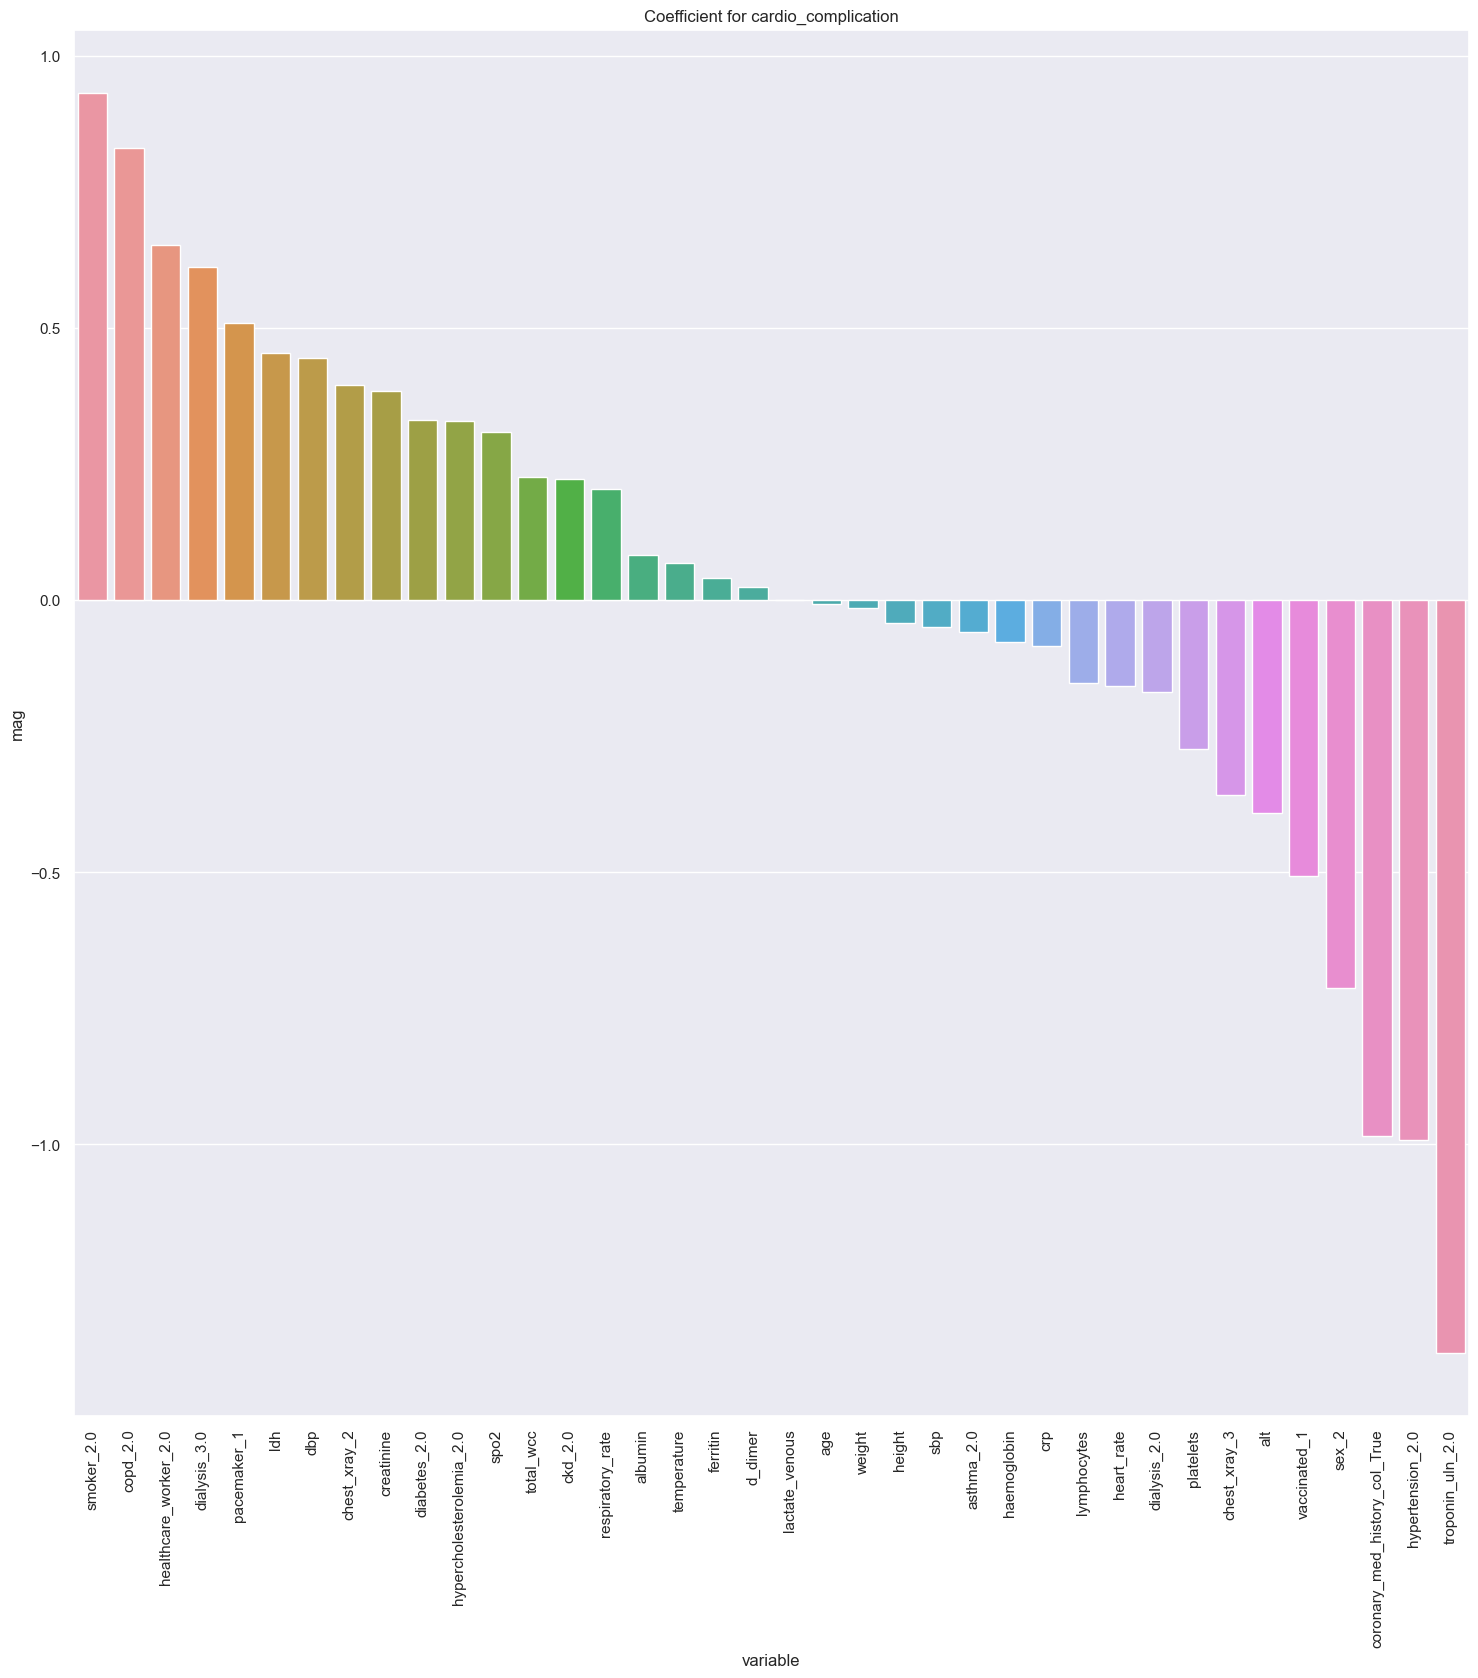

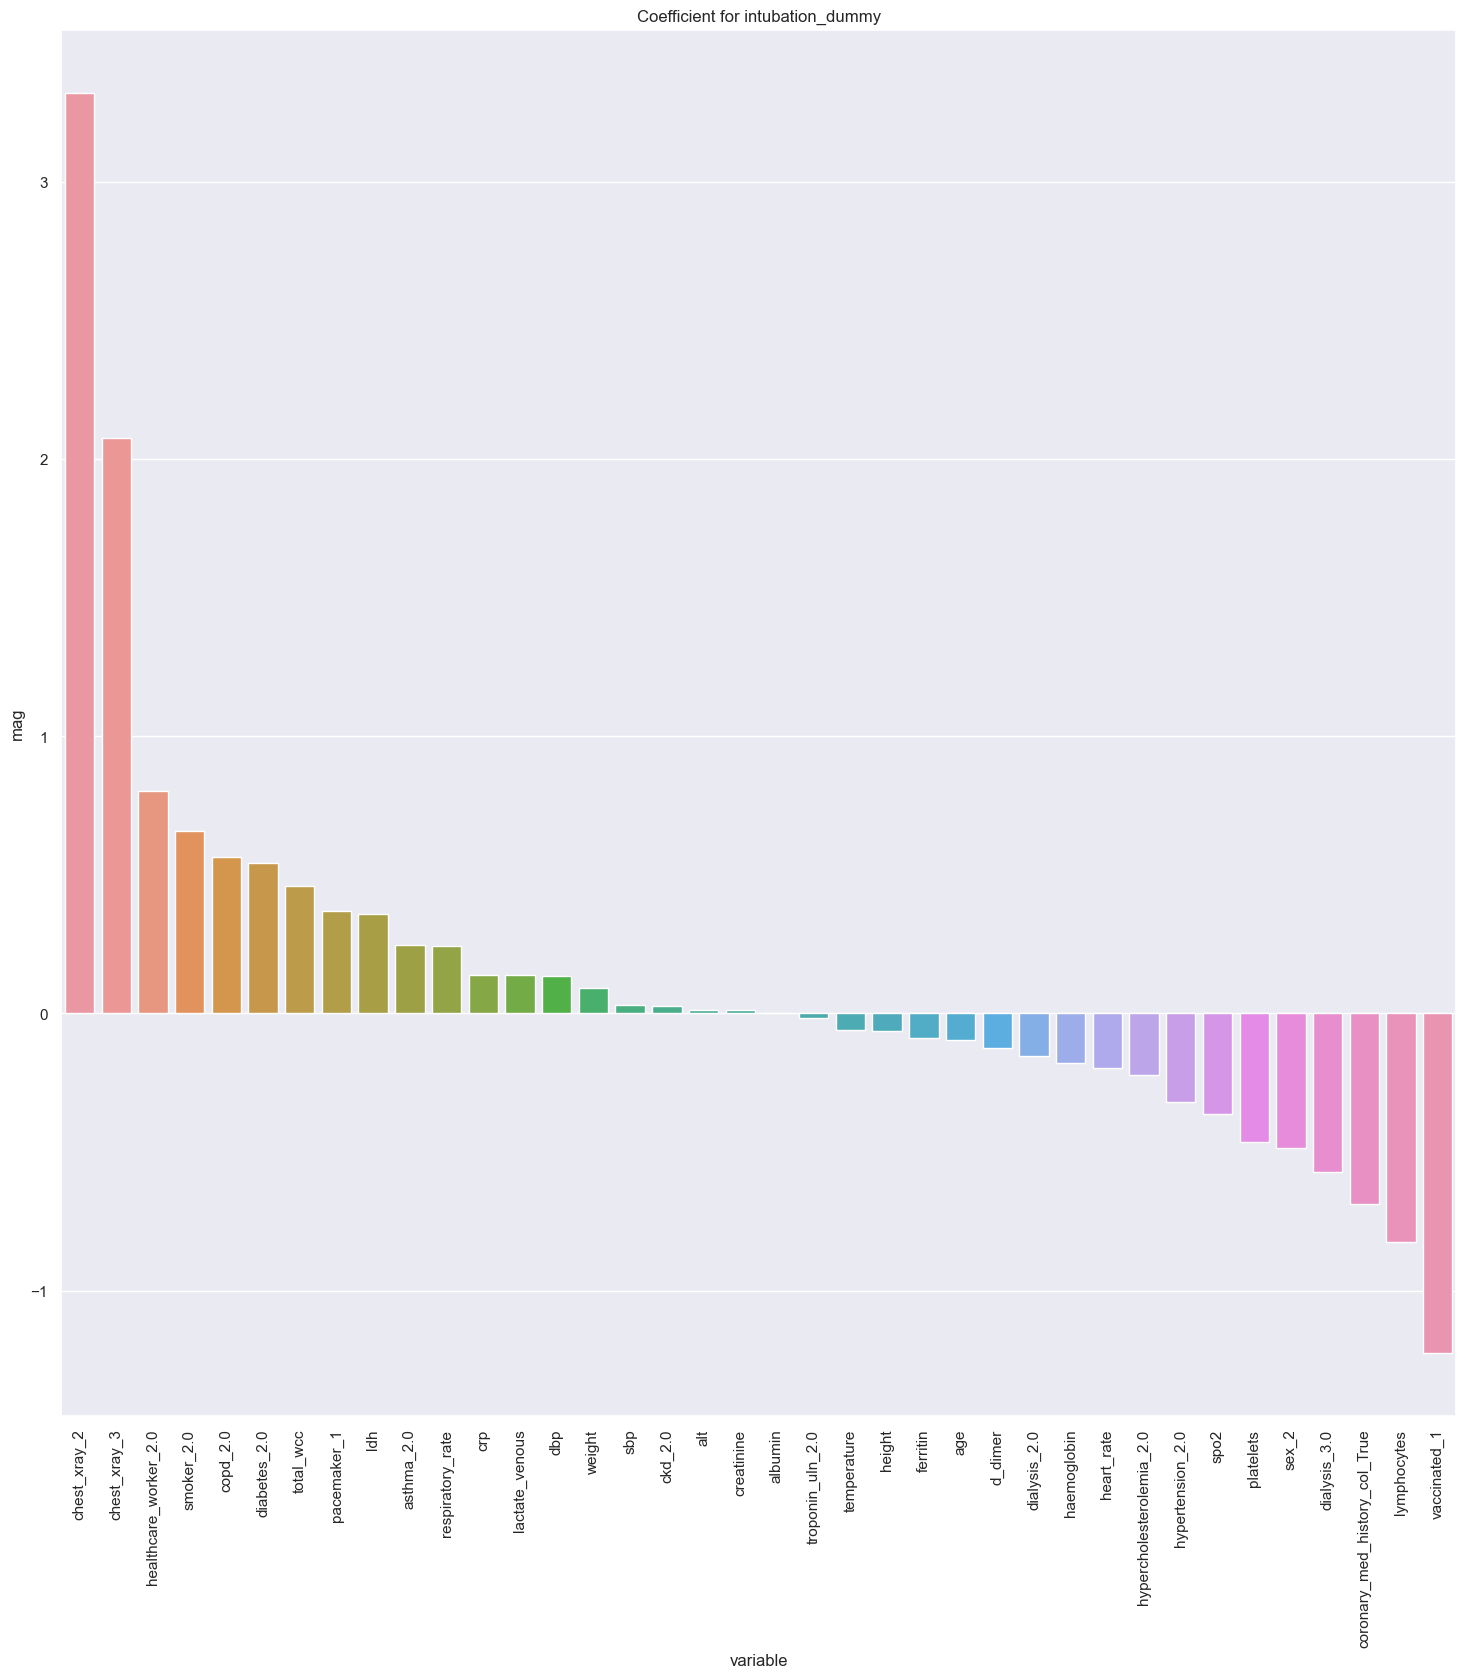

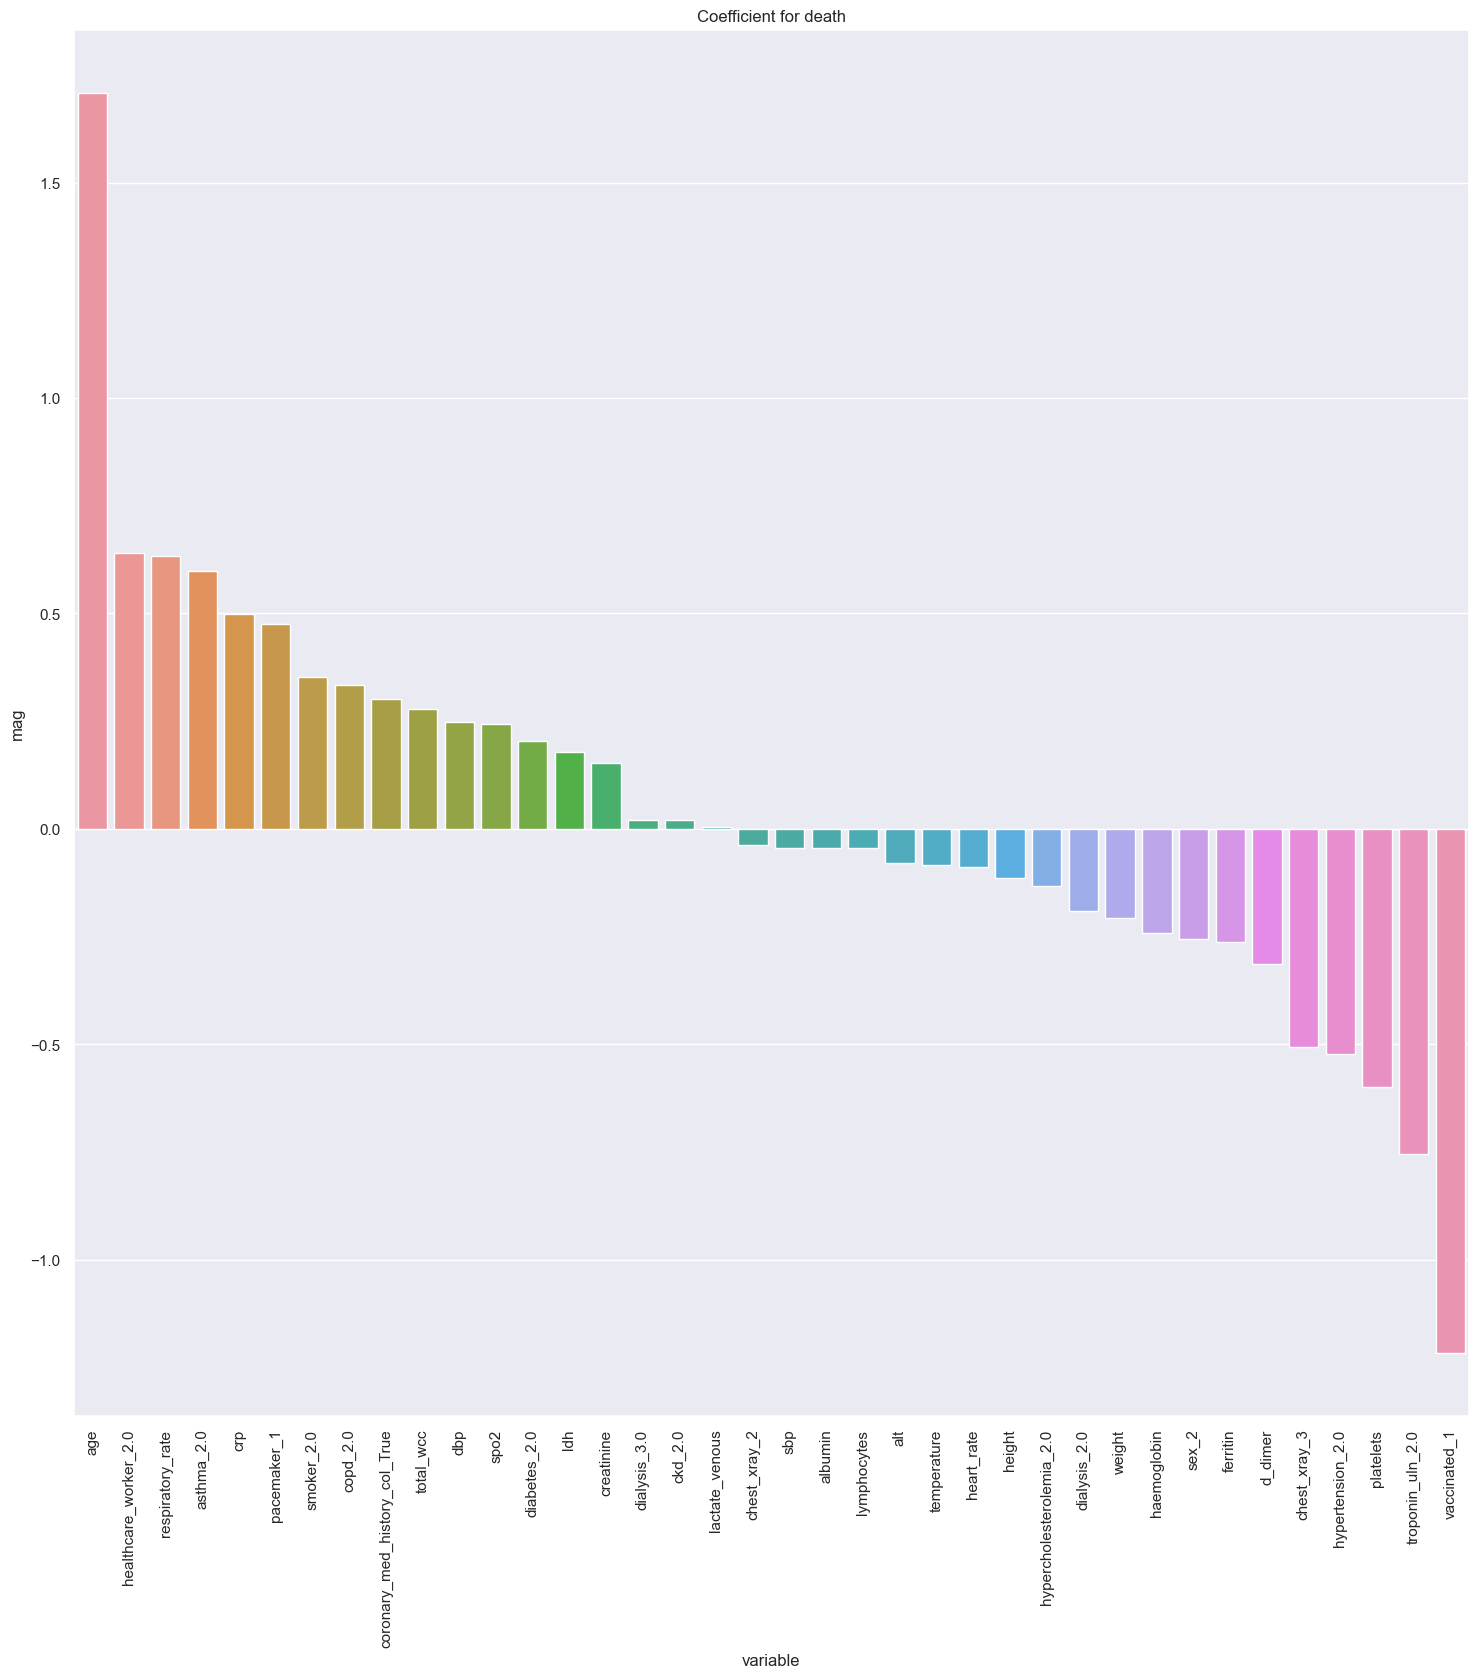

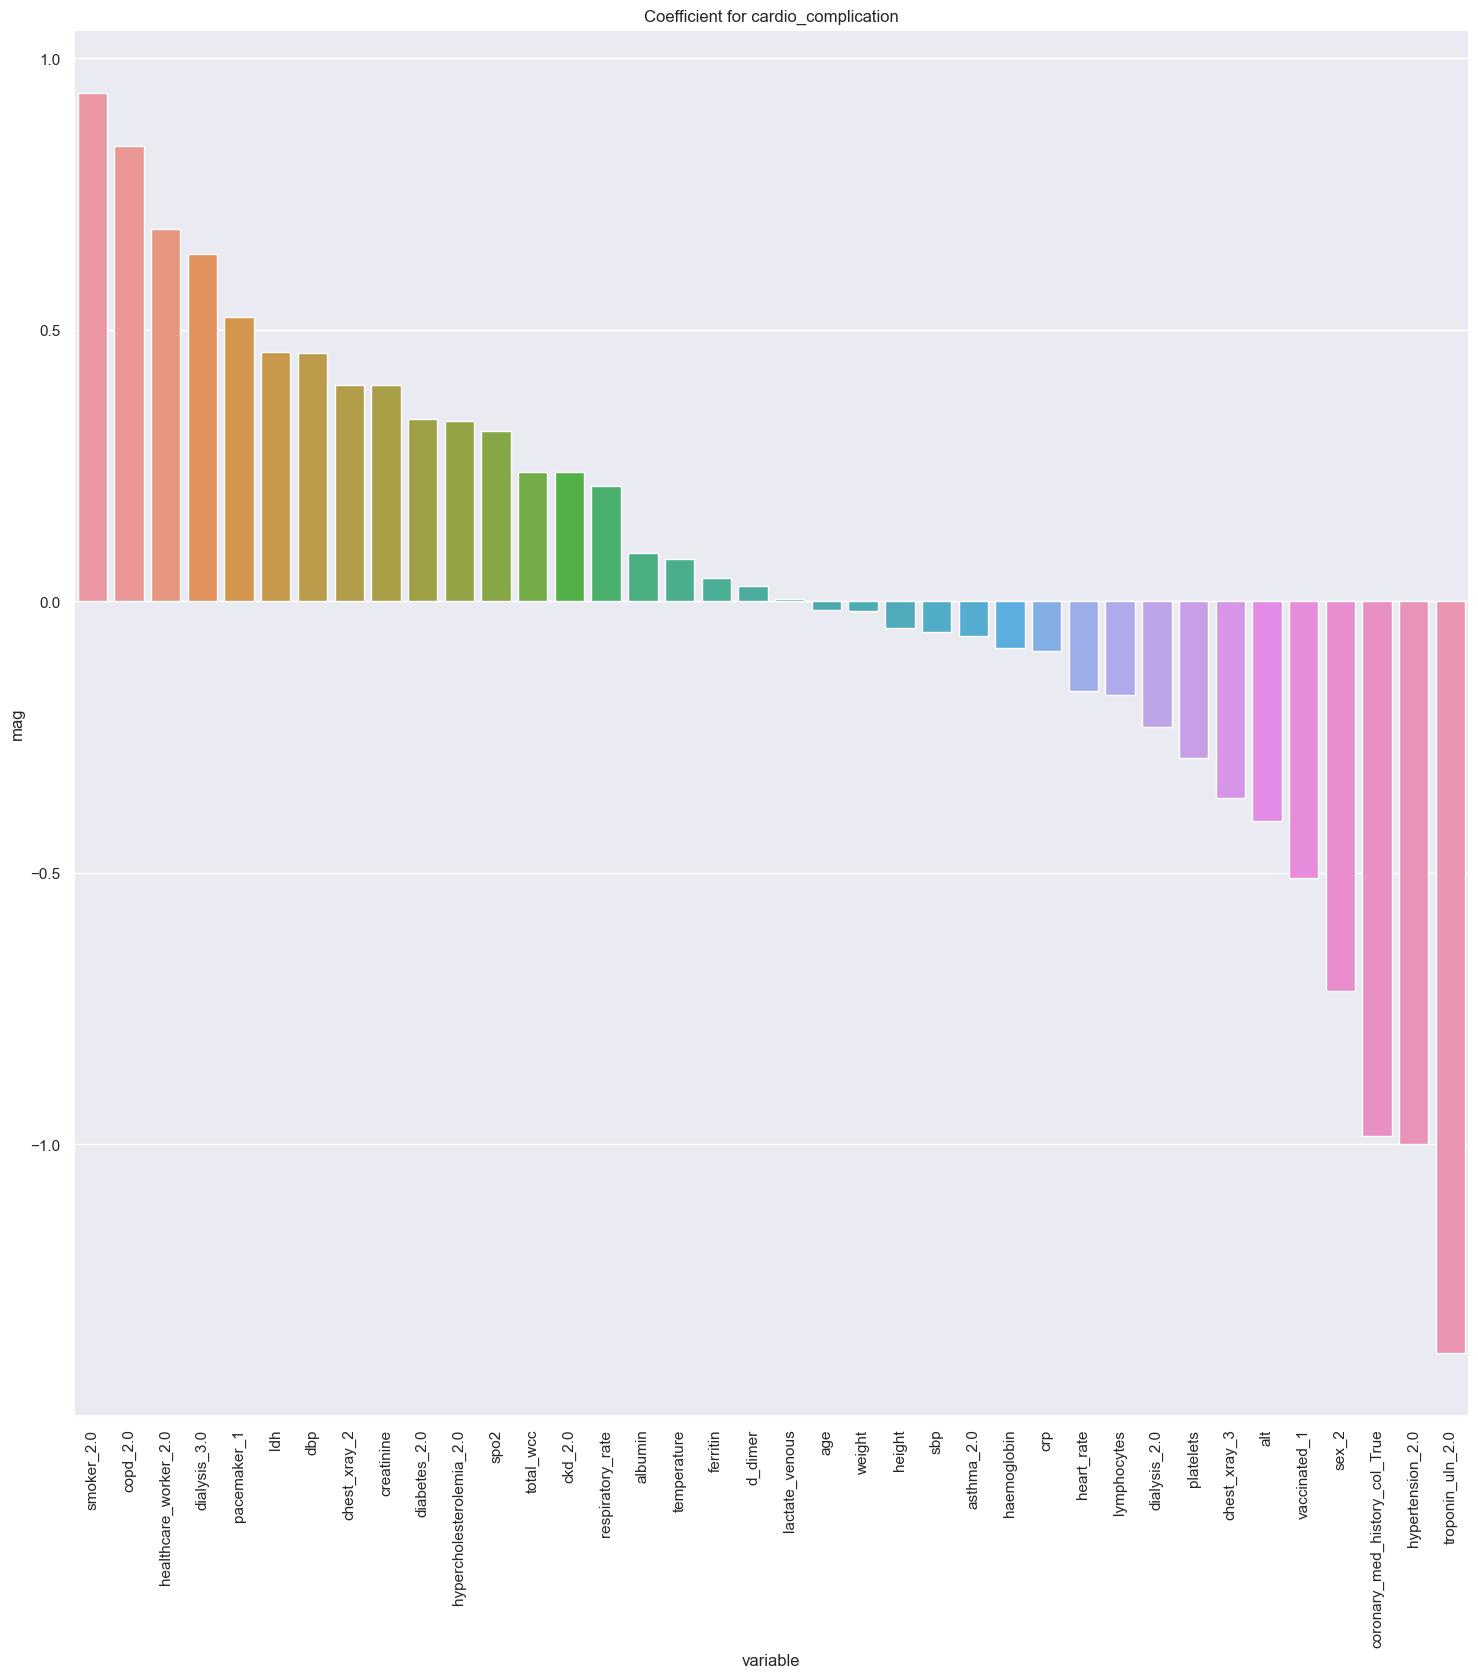

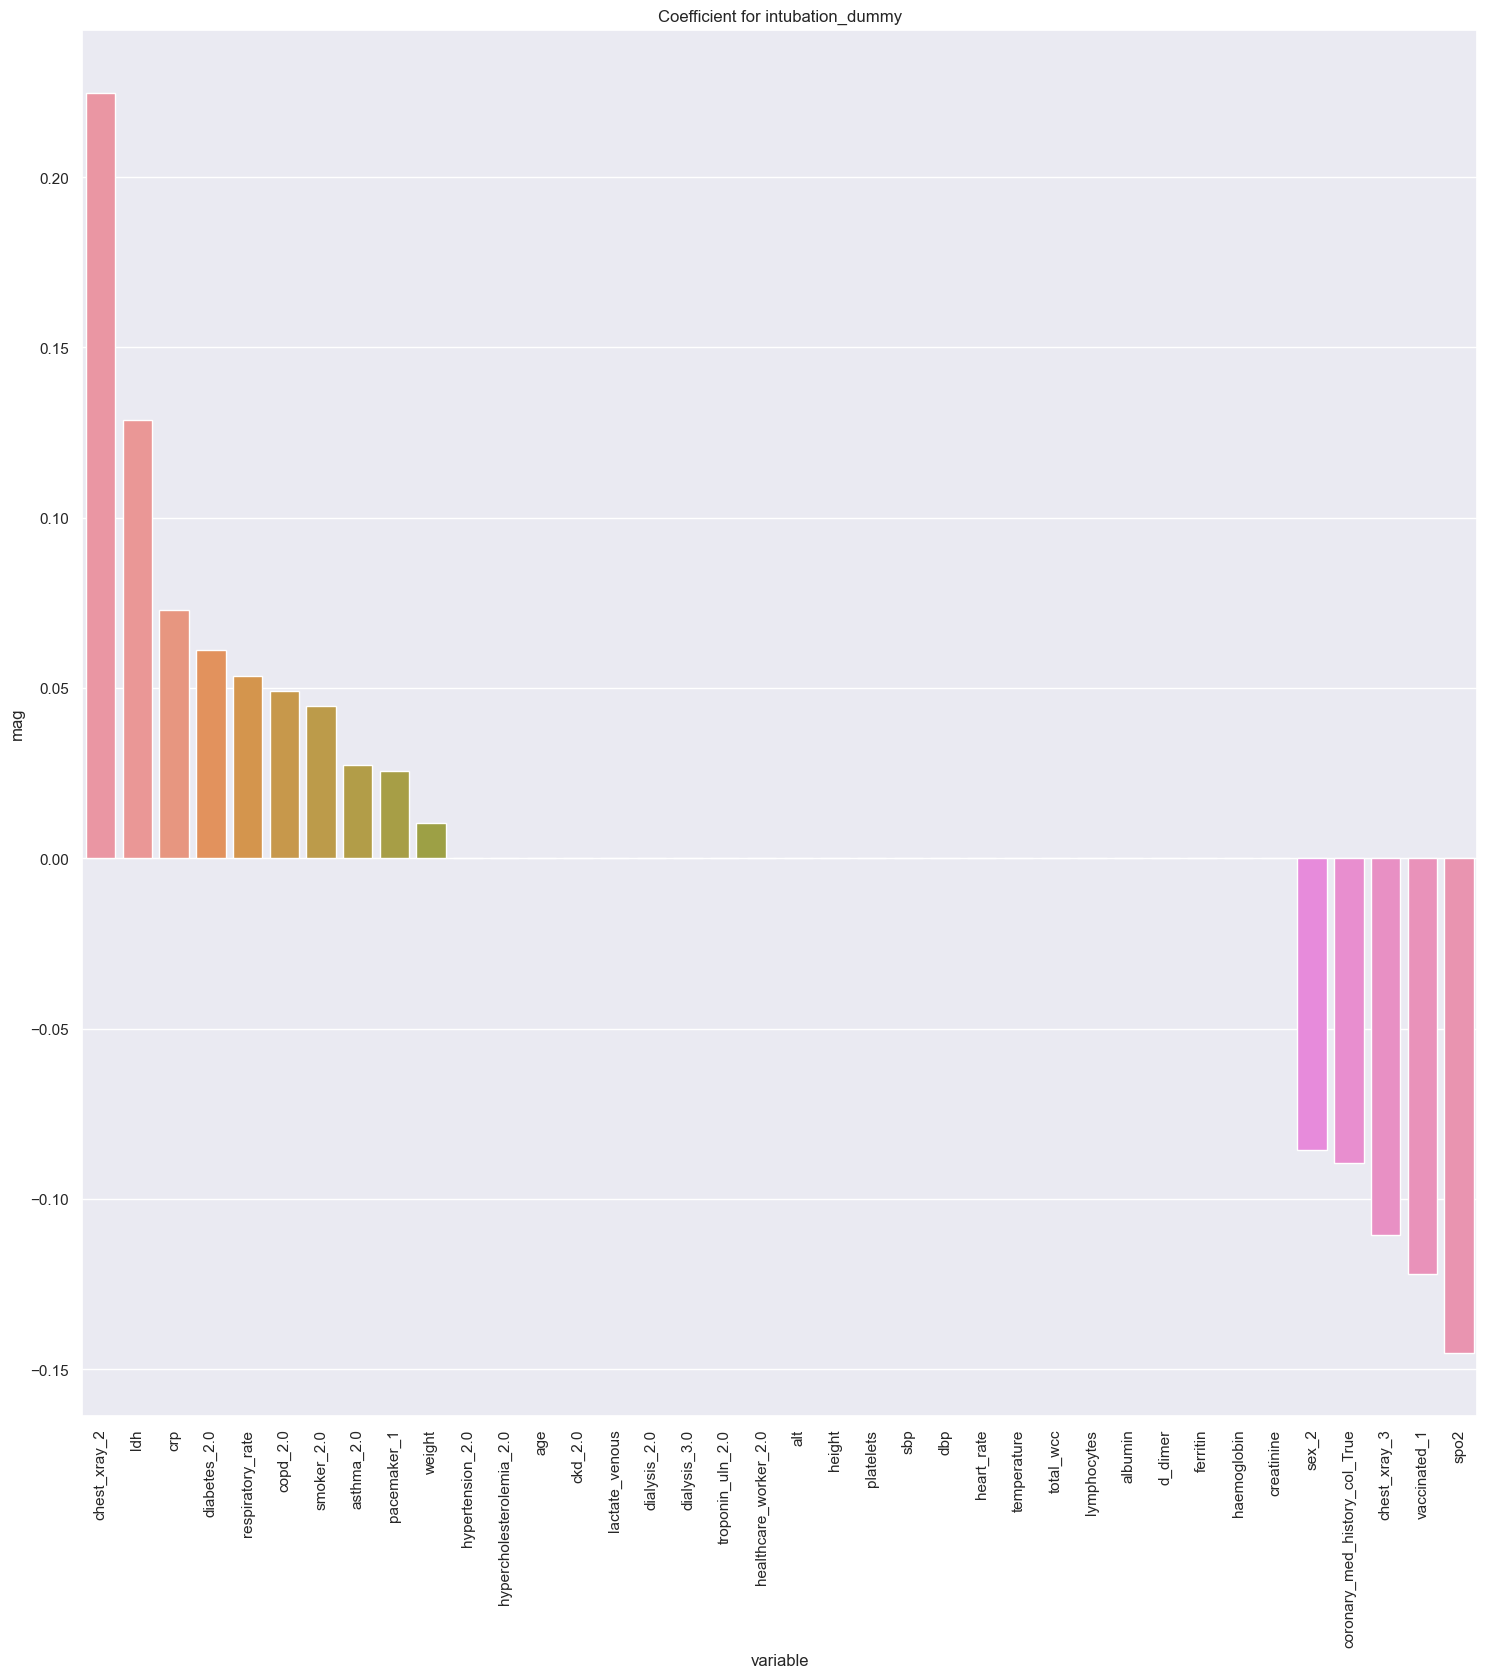

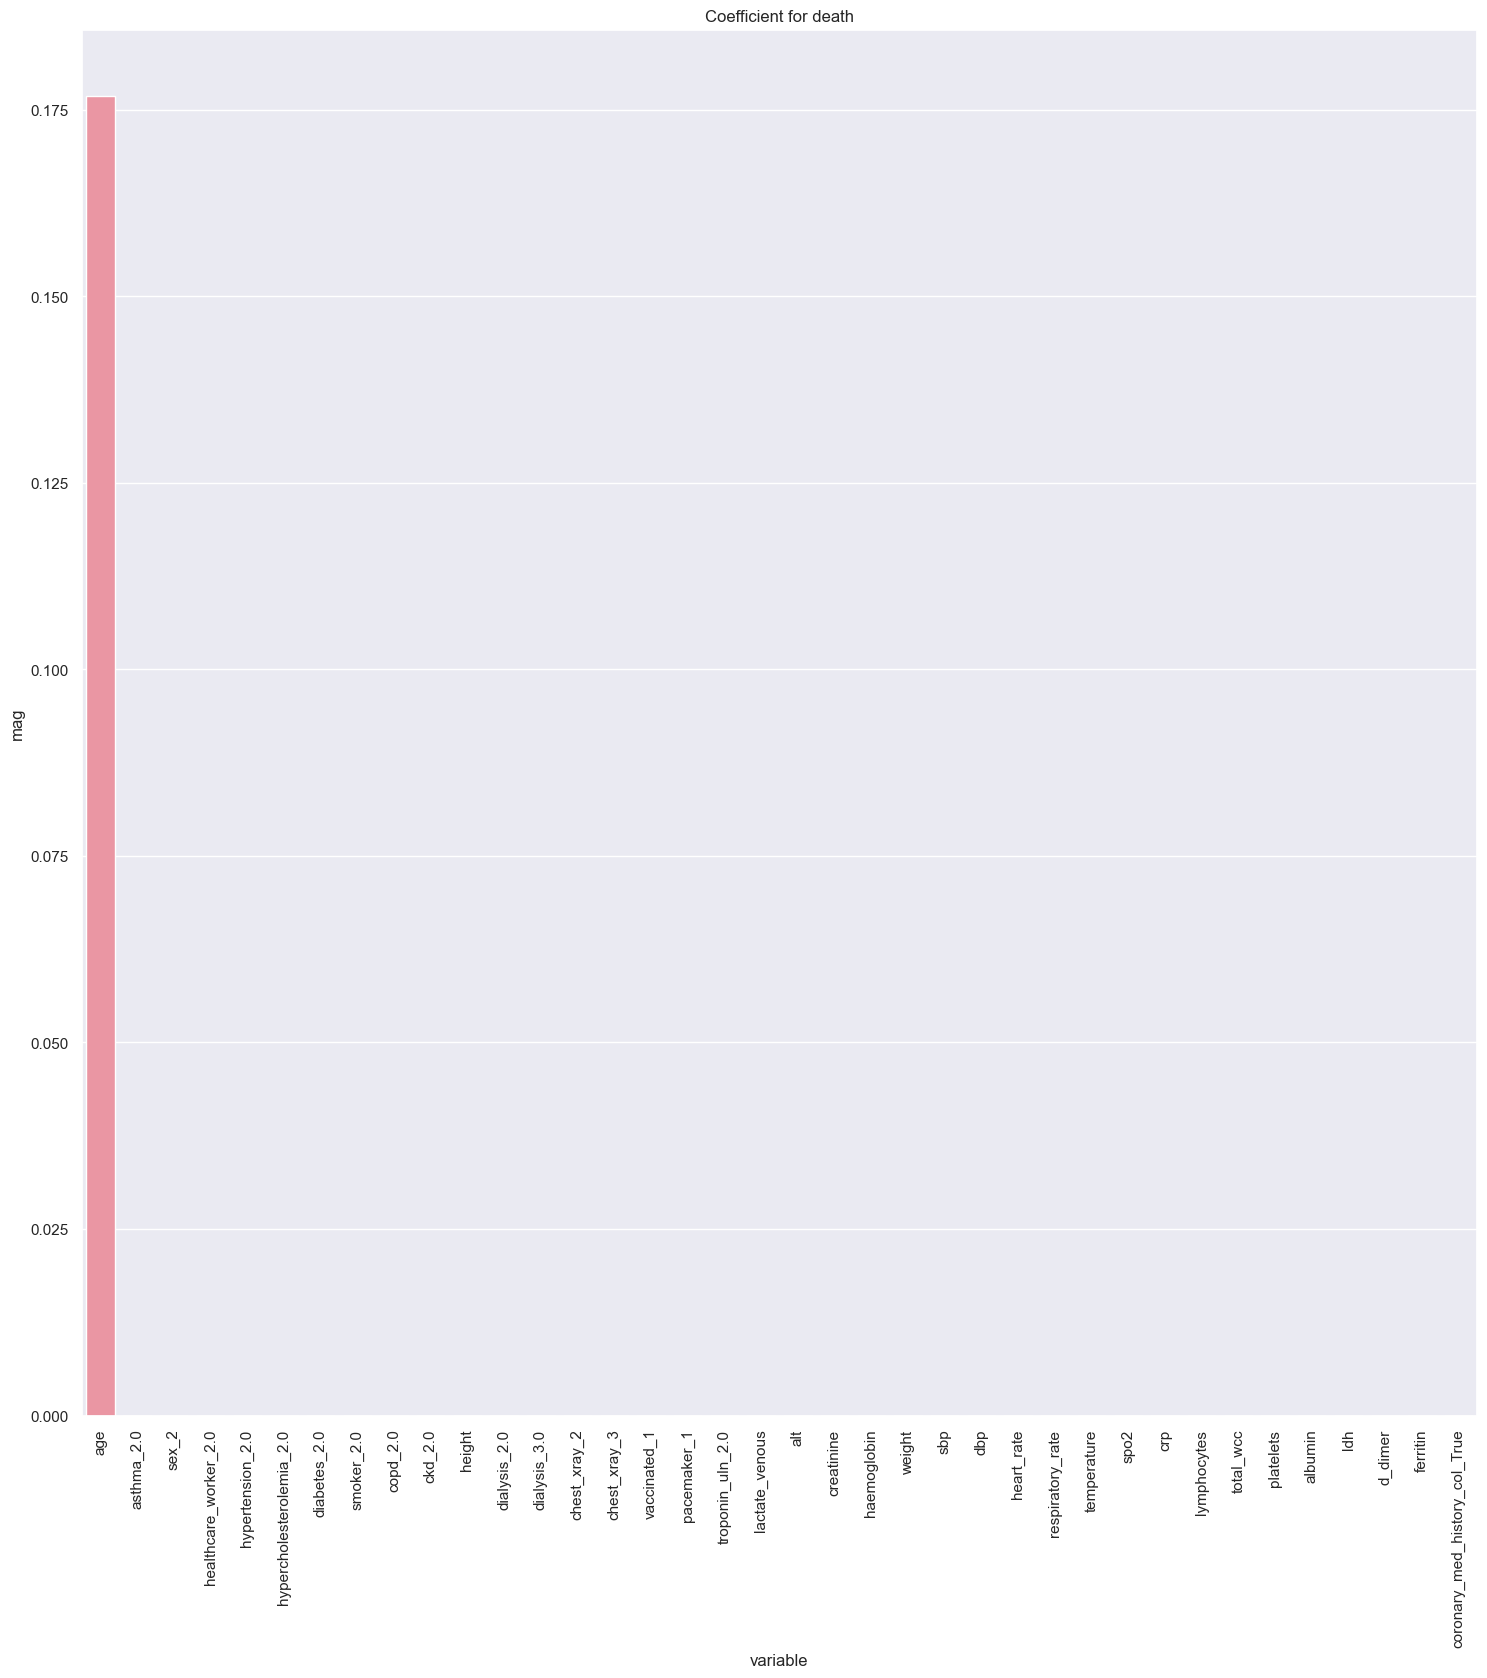

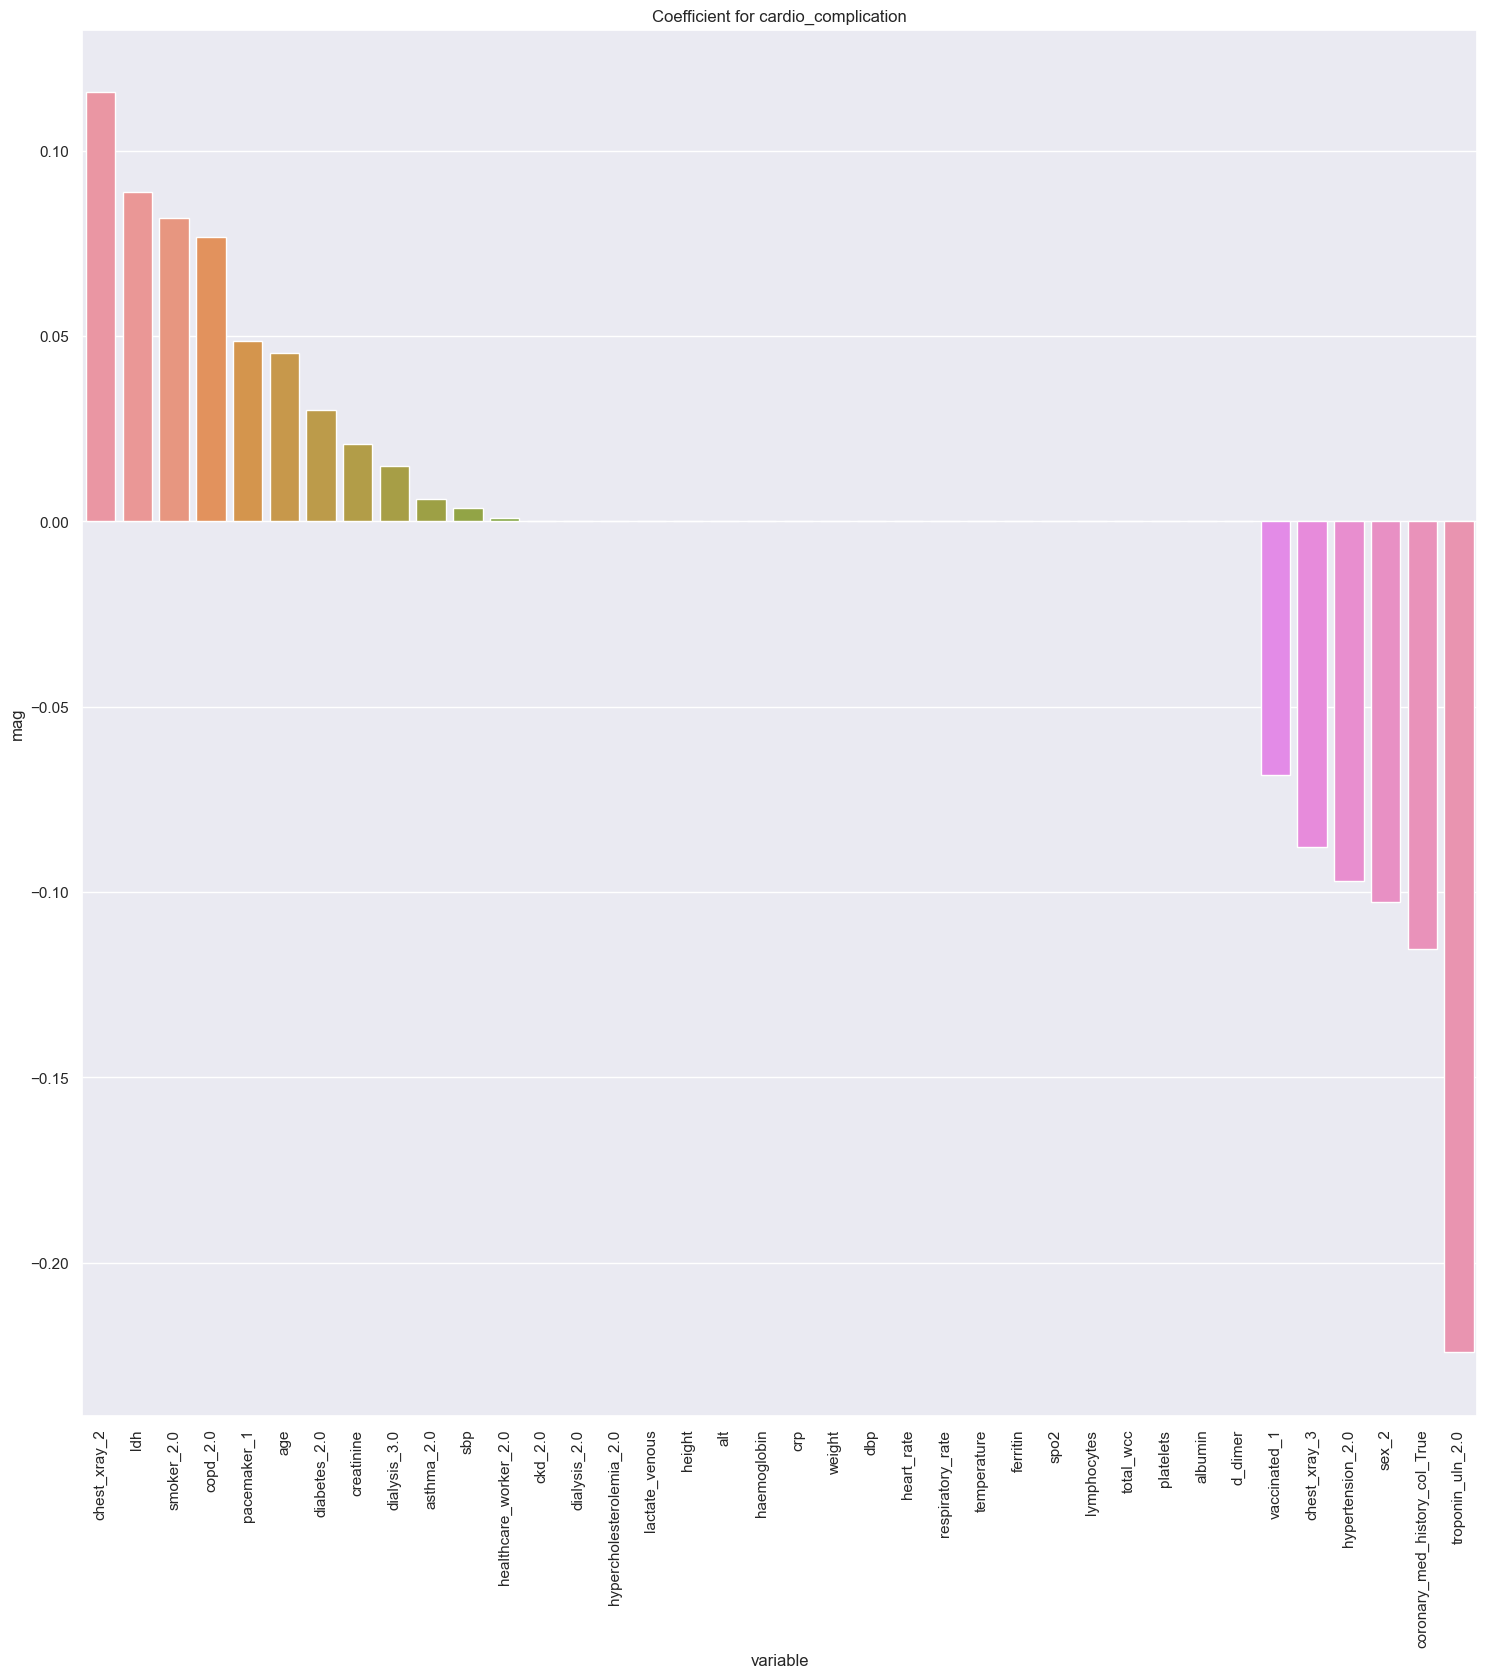

In [24]:
for model_type in ['l1','l2','elasticnet']:
    for n in n_features:
        for use_oversample in [True]:
            for p in predictor:
                if use_oversample:
                    model_name = model_type + "_feature_selection" +str(n)+ "_oversample_oversample"
                else:
                    model_name = model_type + "_feature_selection" +str(n)
                pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
                ax = plot_coef(pipe,model_name,X_train.columns)

In [25]:
for model_type in ['l1','l2','elasticnet']:
    for n in n_features:
        for use_oversample in [True]:
            for p in predictor:
                if use_oversample:
                    model_name = model_type + "_feature_selection" +str(n)+ "_oversample_oversample"
                else:
                    model_name = model_type + "_feature_selection" +str(n)

                y_test = test[p]
                X_test = test.drop(predictor, axis=1)
                pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
                test_result_df = evaluate_model(pipe,X_test,y_test)
                test_result_df["outcome"] = p
                test_result_df["model"] = model_name

                test_df = pd.concat([test_df,test_result_df],ignore_index=True)

In [26]:
score_df.to_csv(cv_result_filename )
test_df.to_csv(test_result_filename)

## Ensemble

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [28]:
score_df = pd.read_csv(cv_result_filename ,index_col=0)
test_df = pd.read_csv(test_result_filename,index_col=0)

In [29]:
def train_model_gridcv(X,y,y_name,model,model_name,
                       param_grid,
                impute=True,
                scale=True,
                oversample=False,
                feature_select=None,
                categorical_features=None,
               score_method='accuracy'):
    pipeline_steps = []
    
    if impute:
        pipeline_steps.append( ('imputer',SimpleImputer(missing_values=np.nan, strategy='median')))
        
    if scale:
        pipeline_steps.append(  ('scaler',StandardScaler()))
    
    if oversample:
        cat_col_index = [i for i, x in enumerate(X.columns) if x in df_dummy_cat_cols]
        pipeline_steps.append(("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)))
        model_name += '_oversample'
            
    if feature_select is not None:
         pipeline_steps.append(("feature_select",feature_select))
        
    
    pipeline_steps.append(  ('model',model))
    
    pipe = Pipeline(steps = pipeline_steps)
    
    grid = GridSearchCV(pipe,
                    param_grid = param_grid,cv=5,scoring=scoring_method,verbose=10)

    grid.fit(X_train, y_train)
    
    joblib.dump(grid.best_estimator_,"model/" + model_name + "_"+p+".pickle")
    
    
    cv_result = cross_validate(grid.best_estimator_, X, y, cv=5,scoring=scoring)
    results = [{k : v.mean() for k, v in cv_result.items()}]

    df_cv_result = pd.DataFrame(results, index=[model_name])
    df_cv_result["outcome"] = p
    df_cv_result["model"] = model_name
    
    
    return grid.best_estimator_,df_cv_result

In [47]:

pre_train_model = LogisticRegression(random_state=random_seed,max_iter = 5000,penalty = 'l1',n_jobs=4,solver = 'saga')
param_grid = {
    "logistic__C": np.logspace(1e-5,1e1,num=50)
}

for p in predictor:
    for use_oversample in [False,True]:
        y_train = train[p]
        X_train = train.drop(predictor, axis=1)
        model_name = 'l1_baseline'    
        cat_col_index = [i for i, x in enumerate(X_train.columns) if x in df_dummy_cat_cols]
        if use_oversample:
            pre_train_pipeline = [
                    ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
                    ("sampler",SMOTENC(categorical_features=cat_col_index, random_state=random_seed)),
                    ("scaler", StandardScaler()), 
                    ("logistic", pre_train_model)
                ]
            model_name += "_oversample"
        else:
             pre_train_pipeline = [
                ("imputer",SimpleImputer(missing_values=np.nan, strategy='median')),
                ("scaler", StandardScaler()), 
                ("logistic", pre_train_model)
            ]

        pipeline = Pipeline(steps=pre_train_pipeline)

        grid = GridSearchCV(pipeline,
                        param_grid = param_grid,cv=10,scoring=scoring_method)


        grid.fit(X_train, y_train)
        joblib.dump(grid.best_estimator_,"model/" + model_name + "_"+p+".pickle")



In [30]:
for model_type in ['ada','gb','svm','rf','dt']:
#for model_type in ['rf','dt']:
    for n in n_features:
        for use_oversample in [False,True]:
            lr_model_name = "l1_baseline"
            
            if use_oversample:
                lr_model_name += '_oversample'
            for p in predictor:  
                if model_type == 'ada':
                    model_name = "adaboost_feature_selection" + str(n)
                    model = AdaBoostClassifier(random_state=random_seed)
                    param_grid = {
                        "model__n_estimators": np.arange(16,24,2),
                        'model__learning_rate':np.linspace(1e-1,5,num=10), 
                    }
                elif model_type == 'gb':
                    model_name = "gb_feature_selection" + str(n)
                    model = GradientBoostingClassifier(random_state=random_seed,n_estimators=50)
                    param_grid = {
                        "model__max_depth": np.arange(1,5,1),
                        'model__max_features':['sqrt'],
                        'model__learning_rate':np.linspace(1e-5,1e-3,5)
                    }
                elif model_type == 'svm':
                    model_name = "svm_feature_selection" + str(n)
                    model = SVC(random_state=random_seed,probability=True)
                    param_grid = {
                        "model__kernel": ['rbf'],
                        'model__C':np.linspace(1e-1,1,num=10), 
                        #'model__degree':[3,5,7,9], 
                    }
                elif model_type == 'rf':
                    model_name = "rf_feature_selection" + str(n)
                    model = RandomForestClassifier(
                         random_state=random_seed,max_features = 'sqrt')
                    param_grid = {
                        'model__max_depth': np.arange(1,11,1) 
                    }
                elif model_type == 'dt':
                    model_name = "decision_feature_selection" + str(n)
                    model = DecisionTreeClassifier(random_state=random_seed)
                    param_grid = {
                        'model__max_depth': np.arange(1,11,1) 
                    }


                y_train = train[p]
                X_train = train.drop(predictor, axis=1)



                loaded_pipe = joblib.load("model/" + lr_model_name + "_" + p +".pickle")
                feature_select_model =  SelectFromModel(LogisticRegression(**loaded_pipe.named_steps["logistic"].get_params())
                                                      ,max_features=n)

                pipe,df_cv_result = train_model_gridcv(
                                        X_train,
                                        y_train,
                                        p,
                                        model,
                                        model_name,
                                        param_grid,
                                        #feature_select=feature_select_model,
                                        score_method=scoring_method,
                                        oversample=use_oversample)


                score_df = pd.concat([score_df,df_cv_result],ignore_index=True)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 1/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.840 total time=   0.0s
[CV 2/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 2/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.729 total time=   0.0s
[CV 3/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 3/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.817 total time=   0.0s
[CV 4/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 4/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.754 total time=   0.0s
[CV 5/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 5/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.806 total time=   0.0s
[CV 1/5; 2/40] START model__

[CV 1/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.682 total time=   0.0s
[CV 2/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 2/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.661 total time=   0.0s
[CV 3/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 3/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.851 total time=   0.0s
[CV 4/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 4/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.783 total time=   0.0s
[CV 5/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 5/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.715 total time=   0.0s
[CV 1/5; 11/40] START model__learning_rate=1.188888888888889, model__n_estimator

[CV 3/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.590 total time=   0.0s
[CV 4/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 4/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.606 total time=   0.0s
[CV 5/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 5/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.615 total time=   0.0s
[CV 1/5; 19/40] START model__learning_rate=2.277777777777778, model__n_estimators=20
[CV 1/5; 19/40] END model__learning_rate=2.277777777777778, model__n_estimators=20;, score=0.632 total time=   0.0s
[CV 2/5; 19/40] START model__learning_rate=2.277777777777778, model__n_estimators=20
[CV 2/5; 19/40] END model__learning_rate=2.277777777777778, model__n_estimators=20;, score=0.601 total time=   0.0s
[CV 3/5; 19/40] START model__learning_rate=2.277777777777778, model__n_estimator

[CV 5/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.589 total time=   0.0s
[CV 1/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 1/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.632 total time=   0.0s
[CV 2/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 2/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.670 total time=   0.0s
[CV 3/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 3/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.572 total time=   0.0s
[CV 4/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 4/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.656 total time=   0.0s
[CV 5/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimator

[CV 2/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.479 total time=   0.0s
[CV 3/5; 35/40] START model__learning_rate=4.455555555555556, model__n_estimators=20
[CV 3/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.485 total time=   0.0s
[CV 4/5; 35/40] START model__learning_rate=4.455555555555556, model__n_estimators=20
[CV 4/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.511 total time=   0.0s
[CV 5/5; 35/40] START model__learning_rate=4.455555555555556, model__n_estimators=20
[CV 5/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.589 total time=   0.0s
[CV 1/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimators=22
[CV 1/5; 36/40] END model__learning_rate=4.455555555555556, model__n_estimators=22;, score=0.506 total time=   0.0s
[CV 2/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimator

D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 1/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.838 total time=   0.0s
[CV 2/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 2/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.834 total time=   0.0s
[CV 3/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 3/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.842 total time=   0.0s
[CV 4/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 4/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.858 total time=   0.0s
[CV 5/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 5/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.865 total time=   0.0s
[CV 1/5; 2/40] START model__

[CV 3/5; 9/40] END model__learning_rate=1.188888888888889, model__n_estimators=16;, score=0.875 total time=   0.0s
[CV 4/5; 9/40] START model__learning_rate=1.188888888888889, model__n_estimators=16
[CV 4/5; 9/40] END model__learning_rate=1.188888888888889, model__n_estimators=16;, score=0.859 total time=   0.0s
[CV 5/5; 9/40] START model__learning_rate=1.188888888888889, model__n_estimators=16
[CV 5/5; 9/40] END model__learning_rate=1.188888888888889, model__n_estimators=16;, score=0.842 total time=   0.0s
[CV 1/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 1/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.834 total time=   0.0s
[CV 2/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 2/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.860 total time=   0.0s
[CV 3/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18


[CV 2/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.491 total time=   0.0s
[CV 3/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 3/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.747 total time=   0.0s
[CV 4/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 4/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.464 total time=   0.0s
[CV 5/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 5/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.473 total time=   0.0s
[CV 1/5; 19/40] START model__learning_rate=2.277777777777778, model__n_estimators=20
[CV 1/5; 19/40] END model__learning_rate=2.277777777777778, model__n_estimators=20;, score=0.476 total time=   0.0s
[CV 2/5; 19/40] START model__learning_rate=2.277777777777778, model__n_estimator

[CV 1/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.476 total time=   0.0s
[CV 2/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 2/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.742 total time=   0.0s
[CV 3/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 3/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.766 total time=   0.0s
[CV 4/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 4/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.464 total time=   0.0s
[CV 5/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 5/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.442 total time=   0.0s
[CV 1/5; 28/40] START model__learning_rate=3.366666666666667, model__n_estimator

[CV 5/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.442 total time=   0.0s
[CV 1/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimators=22
[CV 1/5; 36/40] END model__learning_rate=4.455555555555556, model__n_estimators=22;, score=0.476 total time=   0.0s
[CV 2/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimators=22
[CV 2/5; 36/40] END model__learning_rate=4.455555555555556, model__n_estimators=22;, score=0.491 total time=   0.0s
[CV 3/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimators=22
[CV 3/5; 36/40] END model__learning_rate=4.455555555555556, model__n_estimators=22;, score=0.515 total time=   0.0s
[CV 4/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimators=22
[CV 4/5; 36/40] END model__learning_rate=4.455555555555556, model__n_estimators=22;, score=0.464 total time=   0.0s
[CV 5/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimator

[CV 2/5; 5/40] END model__learning_rate=0.6444444444444445, model__n_estimators=16;, score=0.583 total time=   0.0s
[CV 3/5; 5/40] START model__learning_rate=0.6444444444444445, model__n_estimators=16
[CV 3/5; 5/40] END model__learning_rate=0.6444444444444445, model__n_estimators=16;, score=0.550 total time=   0.0s
[CV 4/5; 5/40] START model__learning_rate=0.6444444444444445, model__n_estimators=16
[CV 4/5; 5/40] END model__learning_rate=0.6444444444444445, model__n_estimators=16;, score=0.618 total time=   0.0s
[CV 5/5; 5/40] START model__learning_rate=0.6444444444444445, model__n_estimators=16
[CV 5/5; 5/40] END model__learning_rate=0.6444444444444445, model__n_estimators=16;, score=0.545 total time=   0.0s
[CV 1/5; 6/40] START model__learning_rate=0.6444444444444445, model__n_estimators=18
[CV 1/5; 6/40] END model__learning_rate=0.6444444444444445, model__n_estimators=18;, score=0.598 total time=   0.0s
[CV 2/5; 6/40] START model__learning_rate=0.6444444444444445, model__n_estimator

[CV 3/5; 13/40] END model__learning_rate=1.7333333333333336, model__n_estimators=16;, score=0.417 total time=   0.0s
[CV 4/5; 13/40] START model__learning_rate=1.7333333333333336, model__n_estimators=16
[CV 4/5; 13/40] END model__learning_rate=1.7333333333333336, model__n_estimators=16;, score=0.526 total time=   0.0s
[CV 5/5; 13/40] START model__learning_rate=1.7333333333333336, model__n_estimators=16
[CV 5/5; 13/40] END model__learning_rate=1.7333333333333336, model__n_estimators=16;, score=0.437 total time=   0.0s
[CV 1/5; 14/40] START model__learning_rate=1.7333333333333336, model__n_estimators=18
[CV 1/5; 14/40] END model__learning_rate=1.7333333333333336, model__n_estimators=18;, score=0.624 total time=   0.0s
[CV 2/5; 14/40] START model__learning_rate=1.7333333333333336, model__n_estimators=18
[CV 2/5; 14/40] END model__learning_rate=1.7333333333333336, model__n_estimators=18;, score=0.637 total time=   0.0s
[CV 3/5; 14/40] START model__learning_rate=1.7333333333333336, model__n

[CV 4/5; 21/40] END model__learning_rate=2.8222222222222224, model__n_estimators=16;, score=0.462 total time=   0.0s
[CV 5/5; 21/40] START model__learning_rate=2.8222222222222224, model__n_estimators=16
[CV 5/5; 21/40] END model__learning_rate=2.8222222222222224, model__n_estimators=16;, score=0.514 total time=   0.0s
[CV 1/5; 22/40] START model__learning_rate=2.8222222222222224, model__n_estimators=18
[CV 1/5; 22/40] END model__learning_rate=2.8222222222222224, model__n_estimators=18;, score=0.512 total time=   0.0s
[CV 2/5; 22/40] START model__learning_rate=2.8222222222222224, model__n_estimators=18
[CV 2/5; 22/40] END model__learning_rate=2.8222222222222224, model__n_estimators=18;, score=0.446 total time=   0.0s
[CV 3/5; 22/40] START model__learning_rate=2.8222222222222224, model__n_estimators=18
[CV 3/5; 22/40] END model__learning_rate=2.8222222222222224, model__n_estimators=18;, score=0.511 total time=   0.0s
[CV 4/5; 22/40] START model__learning_rate=2.8222222222222224, model__n

[CV 1/5; 30/40] END model__learning_rate=3.911111111111112, model__n_estimators=18;, score=0.512 total time=   0.0s
[CV 2/5; 30/40] START model__learning_rate=3.911111111111112, model__n_estimators=18
[CV 2/5; 30/40] END model__learning_rate=3.911111111111112, model__n_estimators=18;, score=0.434 total time=   0.0s
[CV 3/5; 30/40] START model__learning_rate=3.911111111111112, model__n_estimators=18
[CV 3/5; 30/40] END model__learning_rate=3.911111111111112, model__n_estimators=18;, score=0.508 total time=   0.0s
[CV 4/5; 30/40] START model__learning_rate=3.911111111111112, model__n_estimators=18
[CV 4/5; 30/40] END model__learning_rate=3.911111111111112, model__n_estimators=18;, score=0.490 total time=   0.0s
[CV 5/5; 30/40] START model__learning_rate=3.911111111111112, model__n_estimators=18
[CV 5/5; 30/40] END model__learning_rate=3.911111111111112, model__n_estimators=18;, score=0.432 total time=   0.0s
[CV 1/5; 31/40] START model__learning_rate=3.911111111111112, model__n_estimator

[CV 4/5; 38/40] END model__learning_rate=5.0, model__n_estimators=18;, score=0.490 total time=   0.0s
[CV 5/5; 38/40] START model__learning_rate=5.0, model__n_estimators=18..........
[CV 5/5; 38/40] END model__learning_rate=5.0, model__n_estimators=18;, score=0.514 total time=   0.0s
[CV 1/5; 39/40] START model__learning_rate=5.0, model__n_estimators=20..........
[CV 1/5; 39/40] END model__learning_rate=5.0, model__n_estimators=20;, score=0.512 total time=   0.0s
[CV 2/5; 39/40] START model__learning_rate=5.0, model__n_estimators=20..........
[CV 2/5; 39/40] END model__learning_rate=5.0, model__n_estimators=20;, score=0.434 total time=   0.0s
[CV 3/5; 39/40] START model__learning_rate=5.0, model__n_estimators=20..........
[CV 3/5; 39/40] END model__learning_rate=5.0, model__n_estimators=20;, score=0.508 total time=   0.0s
[CV 4/5; 39/40] START model__learning_rate=5.0, model__n_estimators=20..........
[CV 4/5; 39/40] END model__learning_rate=5.0, model__n_estimators=20;, score=0.490 to

D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 1/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.792 total time=   0.3s
[CV 2/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 2/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.742 total time=   0.3s
[CV 3/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 3/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.756 total time=   0.3s
[CV 4/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 4/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.764 total time=   0.3s
[CV 5/5; 1/40] START model__learning_rate=0.1, model__n_estimators=16...........
[CV 5/5; 1/40] END model__learning_rate=0.1, model__n_estimators=16;, score=0.809 total time=   0.3s
[CV 1/5; 2/40] START model__

[CV 3/5; 9/40] END model__learning_rate=1.188888888888889, model__n_estimators=16;, score=0.662 total time=   0.3s
[CV 4/5; 9/40] START model__learning_rate=1.188888888888889, model__n_estimators=16
[CV 4/5; 9/40] END model__learning_rate=1.188888888888889, model__n_estimators=16;, score=0.745 total time=   0.3s
[CV 5/5; 9/40] START model__learning_rate=1.188888888888889, model__n_estimators=16
[CV 5/5; 9/40] END model__learning_rate=1.188888888888889, model__n_estimators=16;, score=0.796 total time=   0.3s
[CV 1/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 1/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.690 total time=   0.3s
[CV 2/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18
[CV 2/5; 10/40] END model__learning_rate=1.188888888888889, model__n_estimators=18;, score=0.766 total time=   0.4s
[CV 3/5; 10/40] START model__learning_rate=1.188888888888889, model__n_estimators=18


[CV 4/5; 17/40] END model__learning_rate=2.277777777777778, model__n_estimators=16;, score=0.423 total time=   0.3s
[CV 5/5; 17/40] START model__learning_rate=2.277777777777778, model__n_estimators=16
[CV 5/5; 17/40] END model__learning_rate=2.277777777777778, model__n_estimators=16;, score=0.440 total time=   0.3s
[CV 1/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 1/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.483 total time=   0.3s
[CV 2/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 2/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.716 total time=   0.4s
[CV 3/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimators=18
[CV 3/5; 18/40] END model__learning_rate=2.277777777777778, model__n_estimators=18;, score=0.447 total time=   0.4s
[CV 4/5; 18/40] START model__learning_rate=2.277777777777778, model__n_estimator

[CV 5/5; 25/40] END model__learning_rate=3.366666666666667, model__n_estimators=16;, score=0.440 total time=   0.3s
[CV 1/5; 26/40] START model__learning_rate=3.366666666666667, model__n_estimators=18
[CV 1/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.483 total time=   0.3s
[CV 2/5; 26/40] START model__learning_rate=3.366666666666667, model__n_estimators=18
[CV 2/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.634 total time=   0.3s
[CV 3/5; 26/40] START model__learning_rate=3.366666666666667, model__n_estimators=18
[CV 3/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.681 total time=   0.3s
[CV 4/5; 26/40] START model__learning_rate=3.366666666666667, model__n_estimators=18
[CV 4/5; 26/40] END model__learning_rate=3.366666666666667, model__n_estimators=18;, score=0.423 total time=   0.3s
[CV 5/5; 26/40] START model__learning_rate=3.366666666666667, model__n_estimator

[CV 1/5; 34/40] END model__learning_rate=4.455555555555556, model__n_estimators=18;, score=0.673 total time=   0.3s
[CV 2/5; 34/40] START model__learning_rate=4.455555555555556, model__n_estimators=18
[CV 2/5; 34/40] END model__learning_rate=4.455555555555556, model__n_estimators=18;, score=0.634 total time=   0.4s
[CV 3/5; 34/40] START model__learning_rate=4.455555555555556, model__n_estimators=18
[CV 3/5; 34/40] END model__learning_rate=4.455555555555556, model__n_estimators=18;, score=0.681 total time=   0.3s
[CV 4/5; 34/40] START model__learning_rate=4.455555555555556, model__n_estimators=18
[CV 4/5; 34/40] END model__learning_rate=4.455555555555556, model__n_estimators=18;, score=0.697 total time=   0.4s
[CV 5/5; 34/40] START model__learning_rate=4.455555555555556, model__n_estimators=18
[CV 5/5; 34/40] END model__learning_rate=4.455555555555556, model__n_estimators=18;, score=0.704 total time=   0.3s
[CV 1/5; 35/40] START model__learning_rate=4.455555555555556, model__n_estimator

[CV 5/5; 2/40] END model__learning_rate=0.1, model__n_estimators=18;, score=0.841 total time=   0.3s
[CV 1/5; 3/40] START model__learning_rate=0.1, model__n_estimators=20...........
[CV 1/5; 3/40] END model__learning_rate=0.1, model__n_estimators=20;, score=0.839 total time=   0.3s
[CV 2/5; 3/40] START model__learning_rate=0.1, model__n_estimators=20...........
[CV 2/5; 3/40] END model__learning_rate=0.1, model__n_estimators=20;, score=0.841 total time=   0.3s
[CV 3/5; 3/40] START model__learning_rate=0.1, model__n_estimators=20...........
[CV 3/5; 3/40] END model__learning_rate=0.1, model__n_estimators=20;, score=0.839 total time=   0.3s
[CV 4/5; 3/40] START model__learning_rate=0.1, model__n_estimators=20...........
[CV 4/5; 3/40] END model__learning_rate=0.1, model__n_estimators=20;, score=0.831 total time=   0.3s
[CV 5/5; 3/40] START model__learning_rate=0.1, model__n_estimators=20...........
[CV 5/5; 3/40] END model__learning_rate=0.1, model__n_estimators=20;, score=0.843 total ti

[CV 2/5; 11/40] END model__learning_rate=1.188888888888889, model__n_estimators=20;, score=0.827 total time=   0.3s
[CV 3/5; 11/40] START model__learning_rate=1.188888888888889, model__n_estimators=20
[CV 3/5; 11/40] END model__learning_rate=1.188888888888889, model__n_estimators=20;, score=0.796 total time=   0.3s
[CV 4/5; 11/40] START model__learning_rate=1.188888888888889, model__n_estimators=20
[CV 4/5; 11/40] END model__learning_rate=1.188888888888889, model__n_estimators=20;, score=0.833 total time=   0.3s
[CV 5/5; 11/40] START model__learning_rate=1.188888888888889, model__n_estimators=20
[CV 5/5; 11/40] END model__learning_rate=1.188888888888889, model__n_estimators=20;, score=0.819 total time=   0.3s
[CV 1/5; 12/40] START model__learning_rate=1.188888888888889, model__n_estimators=22
[CV 1/5; 12/40] END model__learning_rate=1.188888888888889, model__n_estimators=22;, score=0.824 total time=   0.3s
[CV 2/5; 12/40] START model__learning_rate=1.188888888888889, model__n_estimator

[CV 3/5; 19/40] END model__learning_rate=2.277777777777778, model__n_estimators=20;, score=0.808 total time=   0.3s
[CV 4/5; 19/40] START model__learning_rate=2.277777777777778, model__n_estimators=20
[CV 4/5; 19/40] END model__learning_rate=2.277777777777778, model__n_estimators=20;, score=0.195 total time=   0.3s
[CV 5/5; 19/40] START model__learning_rate=2.277777777777778, model__n_estimators=20
[CV 5/5; 19/40] END model__learning_rate=2.277777777777778, model__n_estimators=20;, score=0.177 total time=   0.3s
[CV 1/5; 20/40] START model__learning_rate=2.277777777777778, model__n_estimators=22
[CV 1/5; 20/40] END model__learning_rate=2.277777777777778, model__n_estimators=22;, score=0.784 total time=   0.3s
[CV 2/5; 20/40] START model__learning_rate=2.277777777777778, model__n_estimators=22
[CV 2/5; 20/40] END model__learning_rate=2.277777777777778, model__n_estimators=22;, score=0.793 total time=   0.4s
[CV 3/5; 20/40] START model__learning_rate=2.277777777777778, model__n_estimator

[CV 4/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.799 total time=   0.3s
[CV 5/5; 27/40] START model__learning_rate=3.366666666666667, model__n_estimators=20
[CV 5/5; 27/40] END model__learning_rate=3.366666666666667, model__n_estimators=20;, score=0.823 total time=   0.3s
[CV 1/5; 28/40] START model__learning_rate=3.366666666666667, model__n_estimators=22
[CV 1/5; 28/40] END model__learning_rate=3.366666666666667, model__n_estimators=22;, score=0.783 total time=   0.3s
[CV 2/5; 28/40] START model__learning_rate=3.366666666666667, model__n_estimators=22
[CV 2/5; 28/40] END model__learning_rate=3.366666666666667, model__n_estimators=22;, score=0.779 total time=   0.3s
[CV 3/5; 28/40] START model__learning_rate=3.366666666666667, model__n_estimators=22
[CV 3/5; 28/40] END model__learning_rate=3.366666666666667, model__n_estimators=22;, score=0.817 total time=   0.3s
[CV 4/5; 28/40] START model__learning_rate=3.366666666666667, model__n_estimator

[CV 5/5; 35/40] END model__learning_rate=4.455555555555556, model__n_estimators=20;, score=0.823 total time=   0.3s
[CV 1/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimators=22
[CV 1/5; 36/40] END model__learning_rate=4.455555555555556, model__n_estimators=22;, score=0.793 total time=   0.3s
[CV 2/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimators=22
[CV 2/5; 36/40] END model__learning_rate=4.455555555555556, model__n_estimators=22;, score=0.779 total time=   0.3s
[CV 3/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimators=22
[CV 3/5; 36/40] END model__learning_rate=4.455555555555556, model__n_estimators=22;, score=0.817 total time=   0.3s
[CV 4/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimators=22
[CV 4/5; 36/40] END model__learning_rate=4.455555555555556, model__n_estimators=22;, score=0.799 total time=   0.3s
[CV 5/5; 36/40] START model__learning_rate=4.455555555555556, model__n_estimator

[CV 4/5; 4/40] END model__learning_rate=0.1, model__n_estimators=22;, score=0.623 total time=   0.3s
[CV 5/5; 4/40] START model__learning_rate=0.1, model__n_estimators=22...........
[CV 5/5; 4/40] END model__learning_rate=0.1, model__n_estimators=22;, score=0.599 total time=   0.3s
[CV 1/5; 5/40] START model__learning_rate=0.6444444444444445, model__n_estimators=16
[CV 1/5; 5/40] END model__learning_rate=0.6444444444444445, model__n_estimators=16;, score=0.575 total time=   0.3s
[CV 2/5; 5/40] START model__learning_rate=0.6444444444444445, model__n_estimators=16
[CV 2/5; 5/40] END model__learning_rate=0.6444444444444445, model__n_estimators=16;, score=0.604 total time=   0.3s
[CV 3/5; 5/40] START model__learning_rate=0.6444444444444445, model__n_estimators=16
[CV 3/5; 5/40] END model__learning_rate=0.6444444444444445, model__n_estimators=16;, score=0.558 total time=   0.3s
[CV 4/5; 5/40] START model__learning_rate=0.6444444444444445, model__n_estimators=16
[CV 4/5; 5/40] END model__lea

[CV 5/5; 12/40] END model__learning_rate=1.188888888888889, model__n_estimators=22;, score=0.512 total time=   0.4s
[CV 1/5; 13/40] START model__learning_rate=1.7333333333333336, model__n_estimators=16
[CV 1/5; 13/40] END model__learning_rate=1.7333333333333336, model__n_estimators=16;, score=0.471 total time=   0.3s
[CV 2/5; 13/40] START model__learning_rate=1.7333333333333336, model__n_estimators=16
[CV 2/5; 13/40] END model__learning_rate=1.7333333333333336, model__n_estimators=16;, score=0.607 total time=   0.3s
[CV 3/5; 13/40] START model__learning_rate=1.7333333333333336, model__n_estimators=16
[CV 3/5; 13/40] END model__learning_rate=1.7333333333333336, model__n_estimators=16;, score=0.549 total time=   0.3s
[CV 4/5; 13/40] START model__learning_rate=1.7333333333333336, model__n_estimators=16
[CV 4/5; 13/40] END model__learning_rate=1.7333333333333336, model__n_estimators=16;, score=0.543 total time=   0.3s
[CV 5/5; 13/40] START model__learning_rate=1.7333333333333336, model__n_

[CV 1/5; 21/40] END model__learning_rate=2.8222222222222224, model__n_estimators=16;, score=0.390 total time=   0.3s
[CV 2/5; 21/40] START model__learning_rate=2.8222222222222224, model__n_estimators=16
[CV 2/5; 21/40] END model__learning_rate=2.8222222222222224, model__n_estimators=16;, score=0.516 total time=   0.3s
[CV 3/5; 21/40] START model__learning_rate=2.8222222222222224, model__n_estimators=16
[CV 3/5; 21/40] END model__learning_rate=2.8222222222222224, model__n_estimators=16;, score=0.575 total time=   0.3s
[CV 4/5; 21/40] START model__learning_rate=2.8222222222222224, model__n_estimators=16
[CV 4/5; 21/40] END model__learning_rate=2.8222222222222224, model__n_estimators=16;, score=0.443 total time=   0.3s
[CV 5/5; 21/40] START model__learning_rate=2.8222222222222224, model__n_estimators=16
[CV 5/5; 21/40] END model__learning_rate=2.8222222222222224, model__n_estimators=16;, score=0.517 total time=   0.3s
[CV 1/5; 22/40] START model__learning_rate=2.8222222222222224, model__n

[CV 2/5; 29/40] END model__learning_rate=3.911111111111112, model__n_estimators=16;, score=0.516 total time=   0.3s
[CV 3/5; 29/40] START model__learning_rate=3.911111111111112, model__n_estimators=16
[CV 3/5; 29/40] END model__learning_rate=3.911111111111112, model__n_estimators=16;, score=0.575 total time=   0.3s
[CV 4/5; 29/40] START model__learning_rate=3.911111111111112, model__n_estimators=16
[CV 4/5; 29/40] END model__learning_rate=3.911111111111112, model__n_estimators=16;, score=0.557 total time=   0.3s
[CV 5/5; 29/40] START model__learning_rate=3.911111111111112, model__n_estimators=16
[CV 5/5; 29/40] END model__learning_rate=3.911111111111112, model__n_estimators=16;, score=0.517 total time=   0.3s
[CV 1/5; 30/40] START model__learning_rate=3.911111111111112, model__n_estimators=18
[CV 1/5; 30/40] END model__learning_rate=3.911111111111112, model__n_estimators=18;, score=0.390 total time=   0.3s
[CV 2/5; 30/40] START model__learning_rate=3.911111111111112, model__n_estimator

[CV 3/5; 37/40] END model__learning_rate=5.0, model__n_estimators=16;, score=0.575 total time=   0.4s
[CV 4/5; 37/40] START model__learning_rate=5.0, model__n_estimators=16..........
[CV 4/5; 37/40] END model__learning_rate=5.0, model__n_estimators=16;, score=0.557 total time=   0.3s
[CV 5/5; 37/40] START model__learning_rate=5.0, model__n_estimators=16..........
[CV 5/5; 37/40] END model__learning_rate=5.0, model__n_estimators=16;, score=0.517 total time=   0.3s
[CV 1/5; 38/40] START model__learning_rate=5.0, model__n_estimators=18..........
[CV 1/5; 38/40] END model__learning_rate=5.0, model__n_estimators=18;, score=0.610 total time=   0.3s
[CV 2/5; 38/40] START model__learning_rate=5.0, model__n_estimators=18..........
[CV 2/5; 38/40] END model__learning_rate=5.0, model__n_estimators=18;, score=0.484 total time=   0.3s
[CV 3/5; 38/40] START model__learning_rate=5.0, model__n_estimators=18..........
[CV 3/5; 38/40] END model__learning_rate=5.0, model__n_estimators=18;, score=0.575 to

[CV 1/5; 6/20] END model__learning_rate=0.0002575, model__max_depth=2, model__max_features=sqrt;, score=0.810 total time=   0.0s
[CV 2/5; 6/20] START model__learning_rate=0.0002575, model__max_depth=2, model__max_features=sqrt
[CV 2/5; 6/20] END model__learning_rate=0.0002575, model__max_depth=2, model__max_features=sqrt;, score=0.719 total time=   0.0s
[CV 3/5; 6/20] START model__learning_rate=0.0002575, model__max_depth=2, model__max_features=sqrt
[CV 3/5; 6/20] END model__learning_rate=0.0002575, model__max_depth=2, model__max_features=sqrt;, score=0.784 total time=   0.0s
[CV 4/5; 6/20] START model__learning_rate=0.0002575, model__max_depth=2, model__max_features=sqrt
[CV 4/5; 6/20] END model__learning_rate=0.0002575, model__max_depth=2, model__max_features=sqrt;, score=0.748 total time=   0.0s
[CV 5/5; 6/20] START model__learning_rate=0.0002575, model__max_depth=2, model__max_features=sqrt
[CV 5/5; 6/20] END model__learning_rate=0.0002575, model__max_depth=2, model__max_features=s

[CV 4/5; 13/20] END model__learning_rate=0.0007525, model__max_depth=1, model__max_features=sqrt;, score=0.746 total time=   0.0s
[CV 5/5; 13/20] START model__learning_rate=0.0007525, model__max_depth=1, model__max_features=sqrt
[CV 5/5; 13/20] END model__learning_rate=0.0007525, model__max_depth=1, model__max_features=sqrt;, score=0.774 total time=   0.0s
[CV 1/5; 14/20] START model__learning_rate=0.0007525, model__max_depth=2, model__max_features=sqrt
[CV 1/5; 14/20] END model__learning_rate=0.0007525, model__max_depth=2, model__max_features=sqrt;, score=0.810 total time=   0.0s
[CV 2/5; 14/20] START model__learning_rate=0.0007525, model__max_depth=2, model__max_features=sqrt
[CV 2/5; 14/20] END model__learning_rate=0.0007525, model__max_depth=2, model__max_features=sqrt;, score=0.719 total time=   0.0s
[CV 3/5; 14/20] START model__learning_rate=0.0007525, model__max_depth=2, model__max_features=sqrt
[CV 3/5; 14/20] END model__learning_rate=0.0007525, model__max_depth=2, model__max_f

D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.855 total time=   0.0s
[CV 2/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.824 total time=   0.0s
[CV 3/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 3/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.791 total time=   0.0s
[CV 4/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 4/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.842 total time=   0.0s
[CV 5/5; 1/20] START model__learning_rate=1e-05, model__max_de

[CV 4/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.863 total time=   0.0s
[CV 5/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 5/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.847 total time=   0.0s
[CV 1/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;, score=0.855 total time=   0.0s
[CV 2/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;, score=0.824 total time=   0.0s
[CV 3/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 3/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;, 

[CV 3/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.838 total time=   0.0s
[CV 4/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.864 total time=   0.0s
[CV 5/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 5/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.846 total time=   0.0s
[CV 1/5; 17/20] START model__learning_rate=0.001, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 17/20] END model__learning_rate=0.001, model__max_depth=1, model__max_features=sqrt;, score=0.855 total time=   0.0s
[CV 2/5; 17/20] START model__learning_rate=0.001, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 17/20] END model__learning_rate=0.001, model__max_depth=1, model__max_features=sqrt;, s

D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.732 total time=   0.0s
[CV 2/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.547 total time=   0.0s
[CV 3/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 3/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.572 total time=   0.0s
[CV 4/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 4/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.729 total time=   0.0s
[CV 5/5; 1/20] START model__learning_rate=1e-05, model__max_de

[CV 3/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.537 total time=   0.0s
[CV 4/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.720 total time=   0.0s
[CV 5/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 5/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.568 total time=   0.0s
[CV 1/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;, score=0.732 total time=   0.0s
[CV 2/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;

[CV 1/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.664 total time=   0.0s
[CV 2/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 2/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.596 total time=   0.0s
[CV 3/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 3/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.530 total time=   0.0s
[CV 4/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.720 total time=   0.0s
[CV 5/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 5/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_f

D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.796 total time=   0.3s
[CV 2/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.730 total time=   0.3s
[CV 3/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 3/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.761 total time=   0.3s
[CV 4/5; 1/20] START model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt
[CV 4/5; 1/20] END model__learning_rate=1e-05, model__max_depth=1, model__max_features=sqrt;, score=0.759 total time=   0.3s
[CV 5/5; 1/20] START model__learning_rate=1e-05, model__max_de

[CV 3/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.794 total time=   0.4s
[CV 4/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.777 total time=   0.4s
[CV 5/5; 8/20] START model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt
[CV 5/5; 8/20] END model__learning_rate=0.0002575, model__max_depth=4, model__max_features=sqrt;, score=0.819 total time=   0.4s
[CV 1/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;, score=0.796 total time=   0.3s
[CV 2/5; 9/20] START model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 9/20] END model__learning_rate=0.000505, model__max_depth=1, model__max_features=sqrt;

[CV 5/5; 15/20] END model__learning_rate=0.0007525, model__max_depth=3, model__max_features=sqrt;, score=0.812 total time=   0.3s
[CV 1/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.768 total time=   0.4s
[CV 2/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 2/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.763 total time=   0.4s
[CV 3/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 3/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt;, score=0.795 total time=   0.4s
[CV 4/5; 16/20] START model__learning_rate=0.0007525, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 16/20] END model__learning_rate=0.0007525, model__max_depth=4, model__max_f

[CV 2/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.877 total time=   0.3s
[CV 3/5; 3/20] START model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt
[CV 3/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.823 total time=   0.3s
[CV 4/5; 3/20] START model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt
[CV 4/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.852 total time=   0.3s
[CV 5/5; 3/20] START model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt
[CV 5/5; 3/20] END model__learning_rate=1e-05, model__max_depth=3, model__max_features=sqrt;, score=0.832 total time=   0.3s
[CV 1/5; 4/20] START model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt
[CV 1/5; 4/20] END model__learning_rate=1e-05, model__max_depth=4, model__max_features=sqrt;, score=0.862 total time=   0.4s

[CV 4/5; 10/20] END model__learning_rate=0.000505, model__max_depth=2, model__max_features=sqrt;, score=0.853 total time=   0.3s
[CV 5/5; 10/20] START model__learning_rate=0.000505, model__max_depth=2, model__max_features=sqrt
[CV 5/5; 10/20] END model__learning_rate=0.000505, model__max_depth=2, model__max_features=sqrt;, score=0.827 total time=   0.3s
[CV 1/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 1/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.852 total time=   0.4s
[CV 2/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 2/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt;, score=0.878 total time=   0.3s
[CV 3/5; 11/20] START model__learning_rate=0.000505, model__max_depth=3, model__max_features=sqrt
[CV 3/5; 11/20] END model__learning_rate=0.000505, model__max_depth=3, model__max_features=s

[CV 1/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.853 total time=   0.3s
[CV 2/5; 18/20] START model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt
[CV 2/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.865 total time=   0.3s
[CV 3/5; 18/20] START model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt
[CV 3/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.815 total time=   0.3s
[CV 4/5; 18/20] START model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt
[CV 4/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.853 total time=   0.3s
[CV 5/5; 18/20] START model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt
[CV 5/5; 18/20] END model__learning_rate=0.001, model__max_depth=2, model__max_features=sqrt;, score=0.827 total tim

[CV 3/5; 5/20] END model__learning_rate=0.0002575, model__max_depth=1, model__max_features=sqrt;, score=0.467 total time=   0.3s
[CV 4/5; 5/20] START model__learning_rate=0.0002575, model__max_depth=1, model__max_features=sqrt
[CV 4/5; 5/20] END model__learning_rate=0.0002575, model__max_depth=1, model__max_features=sqrt;, score=0.750 total time=   0.3s
[CV 5/5; 5/20] START model__learning_rate=0.0002575, model__max_depth=1, model__max_features=sqrt
[CV 5/5; 5/20] END model__learning_rate=0.0002575, model__max_depth=1, model__max_features=sqrt;, score=0.631 total time=   0.3s
[CV 1/5; 6/20] START model__learning_rate=0.0002575, model__max_depth=2, model__max_features=sqrt
[CV 1/5; 6/20] END model__learning_rate=0.0002575, model__max_depth=2, model__max_features=sqrt;, score=0.551 total time=   0.3s
[CV 2/5; 6/20] START model__learning_rate=0.0002575, model__max_depth=2, model__max_features=sqrt
[CV 2/5; 6/20] END model__learning_rate=0.0002575, model__max_depth=2, model__max_features=s

[CV 5/5; 12/20] END model__learning_rate=0.000505, model__max_depth=4, model__max_features=sqrt;, score=0.612 total time=   0.4s
[CV 1/5; 13/20] START model__learning_rate=0.0007525, model__max_depth=1, model__max_features=sqrt
[CV 1/5; 13/20] END model__learning_rate=0.0007525, model__max_depth=1, model__max_features=sqrt;, score=0.555 total time=   0.3s
[CV 2/5; 13/20] START model__learning_rate=0.0007525, model__max_depth=1, model__max_features=sqrt
[CV 2/5; 13/20] END model__learning_rate=0.0007525, model__max_depth=1, model__max_features=sqrt;, score=0.582 total time=   0.4s
[CV 3/5; 13/20] START model__learning_rate=0.0007525, model__max_depth=1, model__max_features=sqrt
[CV 3/5; 13/20] END model__learning_rate=0.0007525, model__max_depth=1, model__max_features=sqrt;, score=0.467 total time=   0.3s
[CV 4/5; 13/20] START model__learning_rate=0.0007525, model__max_depth=1, model__max_features=sqrt
[CV 4/5; 13/20] END model__learning_rate=0.0007525, model__max_depth=1, model__max_fe

[CV 2/5; 20/20] END model__learning_rate=0.001, model__max_depth=4, model__max_features=sqrt;, score=0.546 total time=   0.4s
[CV 3/5; 20/20] START model__learning_rate=0.001, model__max_depth=4, model__max_features=sqrt
[CV 3/5; 20/20] END model__learning_rate=0.001, model__max_depth=4, model__max_features=sqrt;, score=0.536 total time=   0.4s
[CV 4/5; 20/20] START model__learning_rate=0.001, model__max_depth=4, model__max_features=sqrt
[CV 4/5; 20/20] END model__learning_rate=0.001, model__max_depth=4, model__max_features=sqrt;, score=0.702 total time=   0.4s
[CV 5/5; 20/20] START model__learning_rate=0.001, model__max_depth=4, model__max_features=sqrt
[CV 5/5; 20/20] END model__learning_rate=0.001, model__max_depth=4, model__max_features=sqrt;, score=0.612 total time=   0.4s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 1/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.757 tota

[CV 5/5; 9/10] END model__C=0.9, model__kernel=rbf;, score=0.785 total time=   0.1s
[CV 1/5; 10/10] START model__C=1.0, model__kernel=rbf...........................
[CV 1/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.756 total time=   0.1s
[CV 2/5; 10/10] START model__C=1.0, model__kernel=rbf...........................
[CV 2/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.698 total time=   0.1s
[CV 3/5; 10/10] START model__C=1.0, model__kernel=rbf...........................
[CV 3/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.730 total time=   0.1s
[CV 4/5; 10/10] START model__C=1.0, model__kernel=rbf...........................
[CV 4/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.758 total time=   0.1s
[CV 5/5; 10/10] START model__C=1.0, model__kernel=rbf...........................
[CV 5/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.785 total time=   0.1s


D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 1/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.825 total time=   0.1s
[CV 2/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 2/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.818 total time=   0.1s
[CV 3/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 3/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.851 total time=   0.1s
[CV 4/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 4/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.833 total time=   0.1s
[CV 5/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 5/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.806 total time=   0.1s
[CV 1/5; 2/10] START model__C=0.2, model__kernel=rbf............................
[CV 1/5; 2/10] END model__C=0.2, 

[CV 5/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.805 total time=   0.1s


D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 1/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.506 total time=   0.1s
[CV 2/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 2/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.532 total time=   0.1s
[CV 3/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 3/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.588 total time=   0.1s
[CV 4/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 4/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.594 total time=   0.1s
[CV 5/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 5/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.514 total time=   0.1s
[CV 1/5; 2/10] START model__C=0.2, model__kernel=rbf............................
[CV 1/5; 2/10] END model__C=0.2, 

[CV 4/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.597 total time=   0.1s
[CV 5/5; 10/10] START model__C=1.0, model__kernel=rbf...........................
[CV 5/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.516 total time=   0.1s


D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 1/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.685 total time=   1.1s
[CV 2/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 2/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.697 total time=   1.1s
[CV 3/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 3/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.729 total time=   1.1s
[CV 4/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 4/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.754 total time=   1.1s
[CV 5/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 5/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.774 total time=   1.2s
[CV 1/5; 2/10] START model__C=0.2, model__kernel=rbf............................
[CV 1/5; 2/10] END model__C=0.2, 

[CV 4/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.808 total time=   0.8s
[CV 5/5; 10/10] START model__C=1.0, model__kernel=rbf...........................
[CV 5/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.804 total time=   0.9s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 1/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.803 total time=   1.0s
[CV 2/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 2/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.860 total time=   1.0s
[CV 3/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 3/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.775 total time=   0.9s
[CV 4/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 4/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.808 total time=   1.0s
[CV 5/5; 1/10] START model__

[CV 3/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.797 total time=   0.7s
[CV 4/5; 10/10] START model__C=1.0, model__kernel=rbf...........................
[CV 4/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.814 total time=   0.7s
[CV 5/5; 10/10] START model__C=1.0, model__kernel=rbf...........................
[CV 5/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.791 total time=   0.7s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 1/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.544 total time=   1.3s
[CV 2/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 2/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.509 total time=   1.3s
[CV 3/5; 1/10] START model__C=0.1, model__kernel=rbf............................
[CV 3/5; 1/10] END model__C=0.1, model__kernel=rbf;, score=0.554 total time=   1.2s
[CV 4/5; 1/10] START model_

[CV 2/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.519 total time=   0.9s
[CV 3/5; 10/10] START model__C=1.0, model__kernel=rbf...........................
[CV 3/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.577 total time=   0.8s
[CV 4/5; 10/10] START model__C=1.0, model__kernel=rbf...........................
[CV 4/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.563 total time=   0.8s
[CV 5/5; 10/10] START model__C=1.0, model__kernel=rbf...........................
[CV 5/5; 10/10] END model__C=1.0, model__kernel=rbf;, score=0.589 total time=   0.9s
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START model__max_depth=1.........................................
[CV 1/5; 1/10] END ..........model__max_depth=1;, score=0.815 total time=   0.1s
[CV 2/5; 1/10] START model__max_depth=1.........................................
[CV 2/5; 1/10] END ..........model__max_depth=1;, score=0.749 total time=   0.1s
[CV 3/5; 1/10] START model__max_

[CV 3/5; 10/10] END ........model__max_depth=10;, score=0.770 total time=   0.2s
[CV 4/5; 10/10] START model__max_depth=10.......................................
[CV 4/5; 10/10] END ........model__max_depth=10;, score=0.781 total time=   0.2s
[CV 5/5; 10/10] START model__max_depth=10.......................................
[CV 5/5; 10/10] END ........model__max_depth=10;, score=0.836 total time=   0.2s


D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START model__max_depth=1.........................................
[CV 1/5; 1/10] END ..........model__max_depth=1;, score=0.870 total time=   0.1s
[CV 2/5; 1/10] START model__max_depth=1.........................................
[CV 2/5; 1/10] END ..........model__max_depth=1;, score=0.867 total time=   0.1s
[CV 3/5; 1/10] START model__max_depth=1.........................................
[CV 3/5; 1/10] END ..........model__max_depth=1;, score=0.847 total time=   0.1s
[CV 4/5; 1/10] START model__max_depth=1.........................................
[CV 4/5; 1/10] END ..........model__max_depth=1;, score=0.864 total time=   0.1s
[CV 5/5; 1/10] START model__max_depth=1.........................................
[CV 5/5; 1/10] END ..........model__max_depth=1;, score=0.848 total time=   0.1s
[CV 1/5; 2/10] START model__max_depth=2.........................................
[CV 1/5; 2/10] END ..........model__max_depth=2;

D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START model__max_depth=1.........................................
[CV 1/5; 1/10] END ..........model__max_depth=1;, score=0.621 total time=   0.1s
[CV 2/5; 1/10] START model__max_depth=1.........................................
[CV 2/5; 1/10] END ..........model__max_depth=1;, score=0.575 total time=   0.1s
[CV 3/5; 1/10] START model__max_depth=1.........................................
[CV 3/5; 1/10] END ..........model__max_depth=1;, score=0.477 total time=   0.1s
[CV 4/5; 1/10] START model__max_depth=1.........................................
[CV 4/5; 1/10] END ..........model__max_depth=1;, score=0.674 total time=   0.1s
[CV 5/5; 1/10] START model__max_depth=1.........................................
[CV 5/5; 1/10] END ..........model__max_depth=1;, score=0.603 total time=   0.1s
[CV 1/5; 2/10] START model__max_depth=2.........................................
[CV 1/5; 2/10] END ..........model__max_depth=2;

D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Program Files\anacondav2\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START model__max_depth=1.........................................
[CV 1/5; 1/10] END ..........model__max_depth=1;, score=0.792 total time=   0.4s
[CV 2/5; 1/10] START model__max_depth=1.........................................
[CV 2/5; 1/10] END ..........model__max_depth=1;, score=0.713 total time=   0.4s
[CV 3/5; 1/10] START model__max_depth=1.........................................
[CV 3/5; 1/10] END ..........model__max_depth=1;, score=0.766 total time=   0.4s
[CV 4/5; 1/10] START model__max_depth=1.........................................
[CV 4/5; 1/10] END ..........model__max_depth=1;, score=0.768 total time=   0.4s
[CV 5/5; 1/10] START model__max_depth=1.........................................
[CV 5/5; 1/10] END ..........model__max_depth=1;, score=0.792 total time=   0.4s
[CV 1/5; 2/10] START model__max_depth=2.........................................
[CV 1/5; 2/10] END ..........model__max_depth=2;

[CV 1/5; 1/10] END ..........model__max_depth=1;, score=0.852 total time=   0.4s
[CV 2/5; 1/10] START model__max_depth=1.........................................
[CV 2/5; 1/10] END ..........model__max_depth=1;, score=0.871 total time=   0.4s
[CV 3/5; 1/10] START model__max_depth=1.........................................
[CV 3/5; 1/10] END ..........model__max_depth=1;, score=0.822 total time=   0.4s
[CV 4/5; 1/10] START model__max_depth=1.........................................
[CV 4/5; 1/10] END ..........model__max_depth=1;, score=0.839 total time=   0.5s
[CV 5/5; 1/10] START model__max_depth=1.........................................
[CV 5/5; 1/10] END ..........model__max_depth=1;, score=0.846 total time=   0.4s
[CV 1/5; 2/10] START model__max_depth=2.........................................
[CV 1/5; 2/10] END ..........model__max_depth=2;, score=0.851 total time=   0.4s
[CV 2/5; 2/10] START model__max_depth=2.........................................
[CV 2/5; 2/10] END .........

[CV 2/5; 1/10] END ..........model__max_depth=1;, score=0.543 total time=   0.4s
[CV 3/5; 1/10] START model__max_depth=1.........................................
[CV 3/5; 1/10] END ..........model__max_depth=1;, score=0.518 total time=   0.4s
[CV 4/5; 1/10] START model__max_depth=1.........................................
[CV 4/5; 1/10] END ..........model__max_depth=1;, score=0.701 total time=   0.4s
[CV 5/5; 1/10] START model__max_depth=1.........................................
[CV 5/5; 1/10] END ..........model__max_depth=1;, score=0.650 total time=   0.4s
[CV 1/5; 2/10] START model__max_depth=2.........................................
[CV 1/5; 2/10] END ..........model__max_depth=2;, score=0.585 total time=   0.4s
[CV 2/5; 2/10] START model__max_depth=2.........................................
[CV 2/5; 2/10] END ..........model__max_depth=2;, score=0.545 total time=   0.4s
[CV 3/5; 2/10] START model__max_depth=2.........................................
[CV 3/5; 2/10] END .........

[CV 5/5; 2/10] END ..........model__max_depth=2;, score=0.666 total time=   0.0s
[CV 1/5; 3/10] START model__max_depth=3.........................................
[CV 1/5; 3/10] END ..........model__max_depth=3;, score=0.797 total time=   0.0s
[CV 2/5; 3/10] START model__max_depth=3.........................................
[CV 2/5; 3/10] END ..........model__max_depth=3;, score=0.641 total time=   0.0s
[CV 3/5; 3/10] START model__max_depth=3.........................................
[CV 3/5; 3/10] END ..........model__max_depth=3;, score=0.665 total time=   0.0s
[CV 4/5; 3/10] START model__max_depth=3.........................................
[CV 4/5; 3/10] END ..........model__max_depth=3;, score=0.746 total time=   0.0s
[CV 5/5; 3/10] START model__max_depth=3.........................................
[CV 5/5; 3/10] END ..........model__max_depth=3;, score=0.777 total time=   0.0s
[CV 1/5; 4/10] START model__max_depth=4.........................................
[CV 1/5; 4/10] END .........

[CV 5/5; 4/10] END ..........model__max_depth=4;, score=0.829 total time=   0.0s
[CV 1/5; 5/10] START model__max_depth=5.........................................
[CV 1/5; 5/10] END ..........model__max_depth=5;, score=0.811 total time=   0.0s
[CV 2/5; 5/10] START model__max_depth=5.........................................
[CV 2/5; 5/10] END ..........model__max_depth=5;, score=0.845 total time=   0.0s
[CV 3/5; 5/10] START model__max_depth=5.........................................
[CV 3/5; 5/10] END ..........model__max_depth=5;, score=0.775 total time=   0.0s
[CV 4/5; 5/10] START model__max_depth=5.........................................
[CV 4/5; 5/10] END ..........model__max_depth=5;, score=0.769 total time=   0.0s
[CV 5/5; 5/10] START model__max_depth=5.........................................
[CV 5/5; 5/10] END ..........model__max_depth=5;, score=0.839 total time=   0.0s
[CV 1/5; 6/10] START model__max_depth=6.........................................
[CV 1/5; 6/10] END .........

[CV 4/5; 6/10] END ..........model__max_depth=6;, score=0.625 total time=   0.0s
[CV 5/5; 6/10] START model__max_depth=6.........................................
[CV 5/5; 6/10] END ..........model__max_depth=6;, score=0.463 total time=   0.0s
[CV 1/5; 7/10] START model__max_depth=7.........................................
[CV 1/5; 7/10] END ..........model__max_depth=7;, score=0.526 total time=   0.0s
[CV 2/5; 7/10] START model__max_depth=7.........................................
[CV 2/5; 7/10] END ..........model__max_depth=7;, score=0.532 total time=   0.0s
[CV 3/5; 7/10] START model__max_depth=7.........................................
[CV 3/5; 7/10] END ..........model__max_depth=7;, score=0.611 total time=   0.0s
[CV 4/5; 7/10] START model__max_depth=7.........................................
[CV 4/5; 7/10] END ..........model__max_depth=7;, score=0.620 total time=   0.0s
[CV 5/5; 7/10] START model__max_depth=7.........................................
[CV 5/5; 7/10] END .........

[CV 5/5; 6/10] END ..........model__max_depth=6;, score=0.699 total time=   0.2s
[CV 1/5; 7/10] START model__max_depth=7.........................................
[CV 1/5; 7/10] END ..........model__max_depth=7;, score=0.620 total time=   0.2s
[CV 2/5; 7/10] START model__max_depth=7.........................................
[CV 2/5; 7/10] END ..........model__max_depth=7;, score=0.618 total time=   0.2s
[CV 3/5; 7/10] START model__max_depth=7.........................................
[CV 3/5; 7/10] END ..........model__max_depth=7;, score=0.749 total time=   0.2s
[CV 4/5; 7/10] START model__max_depth=7.........................................
[CV 4/5; 7/10] END ..........model__max_depth=7;, score=0.747 total time=   0.2s
[CV 5/5; 7/10] START model__max_depth=7.........................................
[CV 5/5; 7/10] END ..........model__max_depth=7;, score=0.699 total time=   0.2s
[CV 1/5; 8/10] START model__max_depth=8.........................................
[CV 1/5; 8/10] END .........

[CV 1/5; 7/10] END ..........model__max_depth=7;, score=0.706 total time=   0.2s
[CV 2/5; 7/10] START model__max_depth=7.........................................
[CV 2/5; 7/10] END ..........model__max_depth=7;, score=0.783 total time=   0.3s
[CV 3/5; 7/10] START model__max_depth=7.........................................
[CV 3/5; 7/10] END ..........model__max_depth=7;, score=0.766 total time=   0.2s
[CV 4/5; 7/10] START model__max_depth=7.........................................
[CV 4/5; 7/10] END ..........model__max_depth=7;, score=0.760 total time=   0.2s
[CV 5/5; 7/10] START model__max_depth=7.........................................
[CV 5/5; 7/10] END ..........model__max_depth=7;, score=0.836 total time=   0.2s
[CV 1/5; 8/10] START model__max_depth=8.........................................
[CV 1/5; 8/10] END ..........model__max_depth=8;, score=0.719 total time=   0.2s
[CV 2/5; 8/10] START model__max_depth=8.........................................
[CV 2/5; 8/10] END .........

[CV 2/5; 7/10] END ..........model__max_depth=7;, score=0.691 total time=   0.3s
[CV 3/5; 7/10] START model__max_depth=7.........................................
[CV 3/5; 7/10] END ..........model__max_depth=7;, score=0.685 total time=   0.3s
[CV 4/5; 7/10] START model__max_depth=7.........................................
[CV 4/5; 7/10] END ..........model__max_depth=7;, score=0.552 total time=   0.3s
[CV 5/5; 7/10] START model__max_depth=7.........................................
[CV 5/5; 7/10] END ..........model__max_depth=7;, score=0.448 total time=   0.2s
[CV 1/5; 8/10] START model__max_depth=8.........................................
[CV 1/5; 8/10] END ..........model__max_depth=8;, score=0.558 total time=   0.3s
[CV 2/5; 8/10] START model__max_depth=8.........................................
[CV 2/5; 8/10] END ..........model__max_depth=8;, score=0.605 total time=   0.3s
[CV 3/5; 8/10] START model__max_depth=8.........................................
[CV 3/5; 8/10] END .........

In [31]:
for model_type in ['ada','gb','svm','rf','dt']:
#for model_type in ['rf','dt']:
    for n in n_features:
        for use_oversample in [True]:

            for p in predictor:  
                if model_type == 'ada':
                    model_name = "adaboost_feature_selection" + str(n)
                elif model_type == 'gb':
                    model_name = "gb_feature_selection" + str(n)
                elif model_type == 'svm':
                    model_name = "svm_feature_selection" + str(n)
                elif model_type == 'rf':
                    model_name = "rf_feature_selection" + str(n)
                elif model_type == 'dt':
                    model_name = "decision_feature_selection" + str(n)


                if use_oversample:
                    model_name += '_oversample'

                y_test = test[p]
                X_test = test.drop(predictor, axis=1)
                pipe = joblib.load("model/" + model_name + "_" + p +".pickle")
                test_result_df = evaluate_model(pipe,X_test,y_test)
                test_result_df["outcome"] = p
                test_result_df["model"] = model_name

                test_df = pd.concat([test_df,test_result_df],ignore_index=True)

In [32]:
score_df.to_csv(cv_result_filename)
test_df.to_csv(test_result_filename)

In [33]:
test_df

,model,accuracy,precision,recall,f1_score,auc,outcome
0,l1_feature_selection5_oversample_oversample,0.685131,0.142857,0.571429,0.228571,0.633333,intubation_dummy
1,l1_feature_selection5_oversample_oversample,0.830904,0.323944,0.696970,0.442308,0.771065,death
2,l1_feature_selection5_oversample_oversample,0.696793,0.060000,0.375000,0.103448,0.543769,cardio_complication
3,l1_feature_selection10_oversample_oversample,0.752187,0.164706,0.500000,0.247788,0.637302,intubation_dummy
4,l1_feature_selection10_oversample_oversample,0.807580,0.238095,0.454545,0.312500,0.649853,death
...,...,...,...,...,...,...,...
127,rf_feature_selectionall_oversample,0.851312,0.344828,0.606061,0.439560,0.741740,death
128,rf_feature_selectionall_oversample,0.883382,0.071429,0.125000,0.090909,0.522745,cardio_complication
129,decision_feature_selectionall_oversample,0.749271,0.191489,0.642857,0.295082,0.700794,intubation_dummy
130,decision_feature_selectionall_oversample,0.795918,0.271605,0.666667,0.385965,0.738172,death
